In [4]:
import os

import numpy as np
import pandas as pd
pd.options.display.max_colwidth = 200
import polars as pl

import seaborn as sns
import matplotlib.pyplot as plt

from pprint import pprint
from clickhouse_driver import Client

client = Client('localhost', database="thesisproxyheapsizedb")

In [8]:
%%time 

exp_data_sql = """
SELECT
	ex.*
FROM
	experiment ex
"""
exp_df = client.query_dataframe(exp_data_sql)

print(len(exp_df.exp_id.unique().tolist()))
print("\n".join(exp_df.exp_id.unique().tolist()))
print()

# We do not have heap size in the config, so add it manually.
records = list()
for e in exp_df.exp_id.unique():
	for p in e.split("_"):
		if "MBheap" in p:
			heap_size_mb = int(p.replace("MBheap", ""))
			records.append({
				"exp_id": e,
				"heap_size_mb": heap_size_mb,
			})
exp_df = exp_df.merge(pd.DataFrame.from_records(records))

pprint(exp_df.columns)
print()
exp_df

14
thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client
thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client
thesis_group_controlling_proxy_heap_size_8clients_withattacker_1000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client
thesis_group_controlling_proxy_heap_size_8clients_withattacker_1000MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client
thesis_group_controlling_proxy_heap_size_8clients_withattacker_2500MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client
thesis_group_controlling_proxy_heap_size_8clients_withattacker_2500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client
thesis_group_controlling_proxy_heap_size_8clients_withattacker_4000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_c

exp_id  \
0   thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
1   thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
2    thesis_group_controlling_proxy_heap_size_8clients_withattacker_1000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
3    thesis_group_controlling_proxy_heap_size_8clients_withattacker_1000MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
4    thesis_group_controlling_proxy_heap_size_8clients_withattacker_2500MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
5    thesis_group_controlling_proxy_heap_size_8clients_withattacker_2500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
6    thesis_group_controlling_proxy_heap_size_8clients_withattacker_4000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
7    thesis_group_controlling_proxy_heap_size_8clients_withattacker_4000MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
8    thesis_group_controlling_proxy_heap_size_8clients_withattacker_5500MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
9    thesis_group_controlling_proxy_heap_size_8clients_withattacker_5500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
10   thesis_group_controlling_proxy_heap_size_8clients_withattacker_7000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
11   thesis_group_controlling_proxy_heap_size_8clients_withattacker_7000MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
12   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
13   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   

   attacker_rate  server_connections  max_keep_alive_requests  num_clients  \
0        100mbps                 256                        0            8   
1        100mbps                 256                        0            8   
2        100mbps                 256                        0            8   
3        100mbps                 256                        0            8   
4        100mbps                 256                        0            8   
5        100mbps                 256                        0            8   
6        100mbps                 256                        0            8   
7        100mbps                 256                        0            8   
8        100mbps                 256                        0            8   
9        100mbps                 256                        0            8   
10       100mbps                 256                        0            8   
11       100mbps                 256                        0            8   
12       100mbps                 256                        0            8   
13       100mbps                 256                        0            8   

    num_trials  origin_server_duration  attacker_duration  receiver_duration  \
0            5                     140                 30                140   
1            5                     140                 30                140   
2            5                     140                 30                140   
3            5                     140                 30                140   
4            5                     140                 30                140   
5            5                     140                 30                140   
6            5                     140                 30                140   
7            5                     140                 30       

In [9]:
%%time 

fetch_metadata_sql = """
SELECT
	n.node_name,
	dn.dnid,
	dn.node_id,
  dn.exp_id
FROM 
	deployed_node dn
	JOIN node n ON n.node_id = dn.node_id
"""

metadata_df = client.query_dataframe(fetch_metadata_sql)

dnid_map_node_name = dict()
dnid_map_exp_id = dict()
node_id_map_node_name = dict()

for record in metadata_df.to_dict(orient="records"):
  dnid = record["dnid"]
  node_id = record["node_id"]
  node_name = record["node_name"]
  exp_id = record["exp_id"]
  
  assert dnid not in dnid_map_node_name
  dnid_map_node_name[dnid] = node_name
  dnid_map_exp_id[dnid] = exp_id
  
  if node_id in node_id_map_node_name:
    assert node_id_map_node_name[node_id] == node_name
  else:
    node_id_map_node_name[node_id] = node_name
  
client_dnids = set(dnid for dnid, node_name in dnid_map_node_name.items() if node_name.startswith("client"))
attacker_dnids = set(dnid for dnid, node_name in dnid_map_node_name.items() if node_name.startswith("attacker"))

client_node_ids = set(node_id for node_id, node_name in node_id_map_node_name.items() if node_name.startswith("client"))

print(f"{client_dnids=}")
print(f"{attacker_dnids=}")
print(f"{client_node_ids=}")

client_dnids={2, 3, 4, 5, 6, 7, 8, 9, 14, 15, 16, 17, 18, 19, 20, 21, 26, 27, 28, 29, 30, 31, 32, 33, 38, 39, 40, 41, 42, 43, 44, 45, 50, 51, 52, 53, 54, 55, 56, 57, 62, 63, 64, 65, 66, 67, 68, 69, 74, 75, 76, 77, 78, 79, 80, 81, 86, 87, 88, 89, 90, 91, 92, 93, 98, 99, 100, 101, 102, 103, 104, 105, 110, 111, 112, 113, 114, 115, 116, 117, 122, 123, 124, 125, 126, 127, 128, 129, 134, 135, 136, 137, 138, 139, 140, 141, 146, 147, 148, 149, 150, 151, 152, 153, 158, 159, 160, 161, 162, 163, 164, 165}
attacker_dnids={1, 97, 121, 37, 133, 73, 13, 109, 49, 145, 85, 157, 25, 61}
client_node_ids={2, 3, 4, 5, 6, 7, 8, 9}
CPU times: user 13.7 ms, sys: 0 ns, total: 13.7 ms
Wall time: 33.4 ms


In [10]:
client_messages_sql = f"""
WITH client_sends AS (
  SELECT
    dn.exp_id AS exp_id,
    e.observe_timestamp AS observe_timestamp,
    e.trial AS trial,
    e.observer_id AS observer_id,
    e.message_marker AS message_marker,
    cm.coap_retransmitted AS coap_retransmitted
  FROM
    event e
    JOIN message m ON m.message_id = e.message_id
    JOIN coap_message cm ON cm.cmci = m.coap_message
    JOIN deployed_node dn ON dn.dnid = e.observer_id
  WHERE
    e.observer_id IN ({','.join(map(str, client_dnids))})   -- client dnids
    AND m.src_id IN ({','.join(map(str, client_node_ids))}) -- clients are senders (node ID)
), 

client_recvs AS (
  SELECT
    e.observe_timestamp AS observe_timestamp,
    e.trial AS trial,
    e.observer_id AS observer_id,
    e.message_marker AS message_marker,
    cm.coap_code AS response_code
  FROM
    event e
    JOIN message m ON m.message_id = e.message_id
    JOIN coap_message cm ON cm.cmci = m.coap_message
  WHERE
    e.observer_id IN ({','.join(map(str, client_dnids))})   -- client dnids
    AND m.dst_id IN ({','.join(map(str, client_node_ids))}) -- clients are receivers (node ID)
)

SELECT
  client_sends.exp_id AS exp_id,
  client_sends.trial AS trial,
  client_sends.observer_id AS observer_id,
  client_sends.message_marker AS message_marker,
  groupArray(client_recvs.response_code)[1] AS response_code,
  MIN(client_sends.observe_timestamp) AS send_time_sec,
  MIN(client_recvs.observe_timestamp) AS recv_time_sec,
  MIN(client_sends.observe_timestamp) AS first_send_time_sec,
  MAX(client_sends.observe_timestamp) AS last_send_time_sec,
  MIN(client_recvs.observe_timestamp) AS first_recv_time_sec,
  MAX(client_recvs.observe_timestamp) AS last_recv_time_sec,
  1e3 * (MIN(client_recvs.observe_timestamp) - MIN(client_sends.observe_timestamp)) AS rtt_ms_first_transmission,
  1e3 * (MIN(client_recvs.observe_timestamp) - MAX(client_sends.observe_timestamp)) AS rtt_ms_last_transmission,
  COUNT(client_sends.observe_timestamp) AS num_send_observations,
  COUNT(client_recvs.observe_timestamp) AS num_recv_observations,
  SUM(CASE WHEN client_sends.coap_retransmitted = true THEN 1 ELSE 0 END) AS num_retransmissions
FROM client_sends
  LEFT JOIN client_recvs USING (trial, observer_id, message_marker)
GROUP BY 
  exp_id, trial, observer_id, message_marker
ORDER BY
  exp_id, trial, observer_id, message_marker
"""

message_rtt_df = client.query_dataframe(client_messages_sql)
message_rtt_df.observer_id.replace(dnid_map_node_name, inplace=True)

message_rtt_df["successful_message"] = False
message_rtt_df.loc[(message_rtt_df["response_code"] == "content"), "successful_message"] = True

print(message_rtt_df["response_code"].unique())

message_rtt_df = message_rtt_df.merge(exp_df, on="exp_id", how="left")

# Due to left join, we need to eliminate lines that
# have negative RTT, so we NaN them.
message_rtt_df.loc[
  (message_rtt_df["rtt_ms_first_transmission"] < 0)
  | (message_rtt_df["rtt_ms_last_transmission"] < 0)
  ,
  ["rtt_ms_first_transmission", "rtt_ms_last_transmission"]
] = np.nan

message_rtt_df

['content' 'bad_gateway' '']


exp_id  \
0       thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
1       thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
2       thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
3       thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
4       thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
...                                                                                                                                                 ...   
881330   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
881331   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
881332   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
881333   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
881334   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   

        trial observer_id  message_marker response_code  send_time_sec  \
0           1     client1               1       content       0.000000   
1           1     client1               2       content       0.396844   
2           1     client1               3       content       0.457773   
3           1     client1               4       content       0.519089   
4           1     client1               5       content       0.578183   
...       ...         ...             ...           ...            ...   
881330      5     client8          705407       content     125.438349   
881331      5     client8          705408       content     125.491878   
881332      5     client8          705409       content     125.545332   
881333      5     client8          705410       content     125.598869   
881334      5     client8          705411                   125.652417   

        recv_time_sec  first_send_time_sec  last_send_time_sec  \
0            0.381186             0.000000            0.000000   
1            0.455831             0.396844            0.396844   
2            0.516893             0.457773            0.457773   
3            0.575833             0.519089            0.519089   
4            0.634519             0.578183            0.578183   
...               ...                  ...                 ...   
881330     125.491084           125.438349          125.438349   
881331     125.544506           125.491878          125.491878   
881332     125.598054           125.545332          125.545332   
881333     125.651609           125.598869          125.598869   
881334       0.000000           125.652417          125.652417   

        first_recv_time_sec  ...  num_proxy_connections  request_timeout  \
0                  0.381186  ...                     50                5   
1                  0.455831  ...                     50                5   
2                  0.516893  ...                     50                5   
3                  0.575833  ...                     50                5   
4                  0.634519  ...                     50                5   
...                     ...  ...                    ...              ...   
881330           125.491084  ...                     50               

In [11]:
%%time

client_sends_sql = f"""
WITH client_sends AS (
  SELECT
    dn.exp_id AS exp_id,
    e.observe_timestamp AS observe_timestamp,
    e.trial AS trial,
    e.observer_id AS observer_id,
    e.message_marker AS message_marker,
    cm.coap_retransmitted AS coap_retransmitted
  FROM
    event e
    JOIN message m ON m.message_id = e.message_id
    JOIN coap_message cm ON cm.cmci = m.coap_message
    JOIN deployed_node dn ON dn.dnid = e.observer_id
  WHERE
    e.observer_id IN ({','.join(map(str, client_dnids))})   -- client dnids
    AND m.src_id IN ({','.join(map(str, client_node_ids))}) -- clients are senders (node ID)
)

SELECT * FROM client_sends
ORDER BY exp_id, trial, observer_id, message_marker
"""

client_sends_df = client.query_dataframe(client_sends_sql)
client_sends_df.observer_id.replace(dnid_map_node_name, inplace=True)

client_sends_df

CPU times: user 2 s, sys: 358 ms, total: 2.36 s
Wall time: 2.94 s


exp_id  \
0       thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
1       thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
2       thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
3       thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
4       thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
...                                                                                                                                                 ...   
885005   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
885006   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
885007   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
885008   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
885009   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   

        observe_timestamp  trial observer_id  message_marker  \
0                0.000000      1     client1               1   
1                0.396844      1     client1               2   
2                0.457773      1     client1               3   
3                0.519089      1     client1               4   
4                0.578183      1     client1               5   
...                   ...    ...         ...             ...   
885005         125.438349      5     client8          705407   
885006         125.491878      5     client8          705408   
885007         125.545332      5     client8          705409   
885008         125.598869      5     client8          705410   
885009         125.652417      5     client8          705411   

        coap_retransmitted  
0                    False  
1                    False  
2                    False  
3                    False  
4                    False  
...                    ...  
885005               False  
885006               False  
885007               False  
885008               False  
885009               False  

[885010 rows x 6 columns]

In [12]:
%%time

client_recvs_sql = f"""
WITH client_recvs AS (
  SELECT
    dn.exp_id AS exp_id,
    e.observe_timestamp AS observe_timestamp,
    e.trial AS trial,
    e.observer_id AS observer_id,
    e.message_marker AS message_marker,
    cm.coap_code AS response_code
  FROM
    event e
    JOIN message m ON m.message_id = e.message_id
    JOIN coap_message cm ON cm.cmci = m.coap_message
    JOIN deployed_node dn ON dn.dnid = e.observer_id
  WHERE
    e.observer_id IN ({','.join(map(str, client_dnids))})   -- client dnids
    AND m.dst_id IN ({','.join(map(str, client_node_ids))}) -- clients are receivers (node ID)
)

SELECT * FROM client_recvs
ORDER BY exp_id, trial, observer_id, message_marker
"""

client_recvs_df = client.query_dataframe(client_recvs_sql)
client_recvs_df.observer_id.replace(dnid_map_node_name, inplace=True)

client_recvs_df["successful_message"] = False
client_recvs_df.loc[(client_recvs_df["response_code"] == "content"), "successful_message"] = True

print(client_recvs_df["response_code"].unique())

client_recvs_df

['content' 'bad_gateway']
CPU times: user 2.4 s, sys: 485 ms, total: 2.89 s
Wall time: 3.42 s


exp_id  \
0       thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
1       thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
2       thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
3       thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
4       thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
...                                                                                                                                                 ...   
880781   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
880782   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
880783   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
880784   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
880785   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   

        observe_timestamp  trial observer_id  message_marker response_code  \
0                0.381186      1     client1               1       content   
1                0.455831      1     client1               2       content   
2                0.516893      1     client1               3       content   
3                0.575833      1     client1               4       content   
4                0.634519      1     client1               5       content   
...                   ...    ...         ...             ...           ...   
880781         125.437553      5     client8          705406       content   
880782         125.491084      5     client8          705407       content   
880783         125.544506      5     client8          705408       content   
880784         125.598054      5     client8          705409       content   
880785         125.651609      5     client8          705410       content   

        successful_message  
0                     True  
1                     True  
2                     True  
3                     True  
4                     True  
...                    ...  
880781                True  
880782                True  
880783                True  
880784                True  
880785                True  

[880786 rows x 7 columns]

In [13]:
%%time

metric_usage_sql = f"""
SELECT
	dn.exp_id,
	nm.trial,
	nm.observer_id,
	nm.metric_type,
	AVG(nm.metric_value) AS avg_value,
	MIN(nm.metric_value) AS min_value,
	MAX(nm.metric_value) AS max_value
FROM
	node_metric nm
	JOIN deployed_node dn ON dn.dnid = nm.observer_id
GROUP BY
	dn.exp_id, nm.trial, nm.observer_id, nm.metric_type
ORDER BY
	dn.exp_id, nm.trial, nm.metric_type, nm.observer_id
"""

metric_df = client.query_dataframe(metric_usage_sql)

metric_df.observer_id.replace(dnid_map_node_name, inplace=True)

metric_df = metric_df.merge(exp_df, on="exp_id", how="left")

metric_df

CPU times: user 23.5 ms, sys: 3.99 ms, total: 27.5 ms
Wall time: 106 ms


exp_id  \
0    thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
1    thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
2    thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
3    thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
4    thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
..                                                                                                                                               ...   
275   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
276   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
277   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
278   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
279   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   

     trial   observer_id         metric_type    avg_value  min_value  \
0        1  originserver     cpu_utilization     5.438571        0.4   
1        1         proxy     cpu_utilization    16.111429        0.5   
2        1  originserver  memory_utilization   283.457851      261.0   
3        1         proxy  memory_utilization  4197.317726      259.0   
4        2  originserver     cpu_utilization     5.285000        0.4   
..     ...           ...                 ...          ...        ...   
275      4         proxy  memory_utilization  3648.215000      259.0   
276      5  originserver     cpu_utilization     5.288571        0.5   
277      5         proxy     cpu_utilization    16.010000        0.4   
278      5  originserver  memory_utilization   283.945455      262.0   
279      5         proxy  memory_utilization  3727.527454      259.0   

     max_value attacker_rate  server_connections  max_keep_alive_requests  \
0         22.2       100mbps                 256                        0   
1         90.4       100mbps                 256                        0   
2        296.0       100mbps                 256                        0   
3       7063.0       100mbps                 256                        0   
4         22.5       100mbps                 256                        0   
..         ...           ...                 ...                      ...   
275     6006.0       100mbps                 256                        0   
276       22.5       100mbps                 256                        0   
277       87.2       100mbps                 256                        0   
278      309.0       100mbps                 256                        0   
279     6112.0       100mbps                 256                        0   

     ...  num_proxy_connections  request_timeout  max_retries  \
0    ...                     50                5            2   
1    ...                     50                5            2   
2    ...                     50                5            2   
3    ...                     50                5            2   
4    ...                     50                5            2   
..   ...                    ...              ...          ...   
275  ...                     50                5            2   
276  ..

In [14]:
%%time

client_rps_df = (
  message_rtt_df
  .groupby(by=["exp_id", "trial", "observer_id"])
  .aggregate(
    num_messages=("successful_message", "count"),
    num_successful_messages=("successful_message", "sum"),
    mean_rps=("successful_message", "sum"),
    max_num_retransmissions=("num_retransmissions", "max"),
    total_num_retransmissions=("num_retransmissions", "sum"),
    stddev_rtt_ms=("rtt_ms_first_transmission", "std"),
    min_rtt_ms=("rtt_ms_first_transmission", "min"),
    median_rtt_ms=("rtt_ms_first_transmission", "median"),
    mean_rtt_ms=("rtt_ms_first_transmission", "mean"),
    max_rtt_ms=("rtt_ms_first_transmission", "max"),
    rtt_ms_p0=("rtt_ms_first_transmission", lambda s : pd.Series.quantile(s, q=0.00)),
    rtt_ms_p25=("rtt_ms_first_transmission", lambda s : pd.Series.quantile(s, q=0.25)),
    rtt_ms_p50=("rtt_ms_first_transmission", lambda s : pd.Series.quantile(s, q=0.50)),
    rtt_ms_p75=("rtt_ms_first_transmission", lambda s : pd.Series.quantile(s, q=0.75)),
    rtt_ms_p90=("rtt_ms_first_transmission", lambda s : pd.Series.quantile(s, q=0.90)),
    rtt_ms_p99=("rtt_ms_first_transmission", lambda s : pd.Series.quantile(s, q=0.99)),
    rtt_ms_p100=("rtt_ms_first_transmission", lambda s : pd.Series.quantile(s, q=1.00)),
    first_active_time=("first_send_time_sec", "min"),
    last_active_time=("last_recv_time_sec", "max"),
  )
  .reset_index()
)
assert client_rps_df["min_rtt_ms"].eq(client_rps_df["rtt_ms_p0"]).all()
assert client_rps_df["median_rtt_ms"].eq(client_rps_df["rtt_ms_p50"]).all()
assert client_rps_df["max_rtt_ms"].eq(client_rps_df["rtt_ms_p100"]).all()

client_rps_df["num_failed_messages"] = client_rps_df["num_messages"] - client_rps_df["num_successful_messages"]
client_rps_df["average_rps"] = client_rps_df["num_successful_messages"] / (client_rps_df["last_active_time"] - client_rps_df["first_active_time"])

client_rps_df = client_rps_df.merge(exp_df, on="exp_id")
bool_col_replacement = {
  "run_proxy_with_dtls": {True: "dtls", False: "coap"},
  "run_proxy_with_https": {True: "https", False: "http"},
  "reuse_connections": {True: "reuse-connections", False: "no-connection-reuse"},
  "run_attacker": {True: "attacker", False: "no-attacker"},
}
client_rps_df.replace(bool_col_replacement, inplace=True)

client_rps_df["mean_rps"] /= client_rps_df["client_duration"]

client_rps_df[["exp_id", "trial", "observer_id", "mean_rps"]]

client_rps_df

CPU times: user 4.29 s, sys: 252 µs, total: 4.29 s
Wall time: 4.29 s


exp_id  \
0    thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
1    thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
2    thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
3    thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
4    thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
..                                                                                                                                               ...   
555   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
556   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
557   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
558   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
559   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   

     trial observer_id  num_messages  num_successful_messages   mean_rps  \
0        1     client1          1574                     1567  13.058333   
1        1     client2          1585                     1579  13.158333   
2        1     client3          1583                     1577  13.141667   
3        1     client4          1578                     1573  13.108333   
4        1     client5          1584                     1578  13.150000   
..     ...         ...           ...                      ...        ...   
555      5     client4          1563                     1557  12.975000   
556      5     client5          1569                     1565  13.041667   
557      5     client6          1564                     1560  13.000000   
558      5     client7          1572                     1567  13.058333   
559      5     client8          1568                     1562  13.016667   

     max_num_retransmissions  total_num_retransmissions  stddev_rtt_ms  \
0                          1                          6     360.723801   
1                          1                          6     342.388081   
2                          2                          6     382.778461   
3                          1                          6     341.619355   
4                          1                          6     358.057115   
..                       ...                        ...            ...   
555                        1                          6     346.030334   
556                        1                          6     346.663609   
557                        3                          5     632.662160   
558                        1                          7     319.212959   
559                        2                          8     362.166457   

     min_rtt_ms  ...  num_proxy_connections  request_timeout  max_retries  \
0     51.570892  ...                     50                5            2   
1     51.586866  ...                     50                5            2   
2     51.476955  ...                     50                5            2   
3     51.650047  ...                     50                5            2   
4     51.528931  ...                     50                5            2   
..          ...  ...                    ...          

In [27]:
### Dev plotting

import matplotlib as mpl
inline_rc = dict(mpl.rcParams)
mpl.rcParams.update(mpl.rcParamsDefault)

In [28]:
### At this point, we generate figures for the paper

plt.rcParams['figure.dpi']  = 300
plt.rcParams['savefig.dpi'] = 300

plt.rcParams['font.size']        = '18'
plt.rcParams['lines.linewidth']  = 3
plt.rcParams['lines.markersize'] = 9

client_rps_df.replace({
  "run_proxy_with_dtls": {
    "coap": "CoAP",
    "dtls": "CoAPS",
  }
}, inplace=True)

metric_df.replace({
  "run_proxy_with_dtls": {
    False: "CoAP",
    True : "CoAPS",
  }
}, inplace=True)

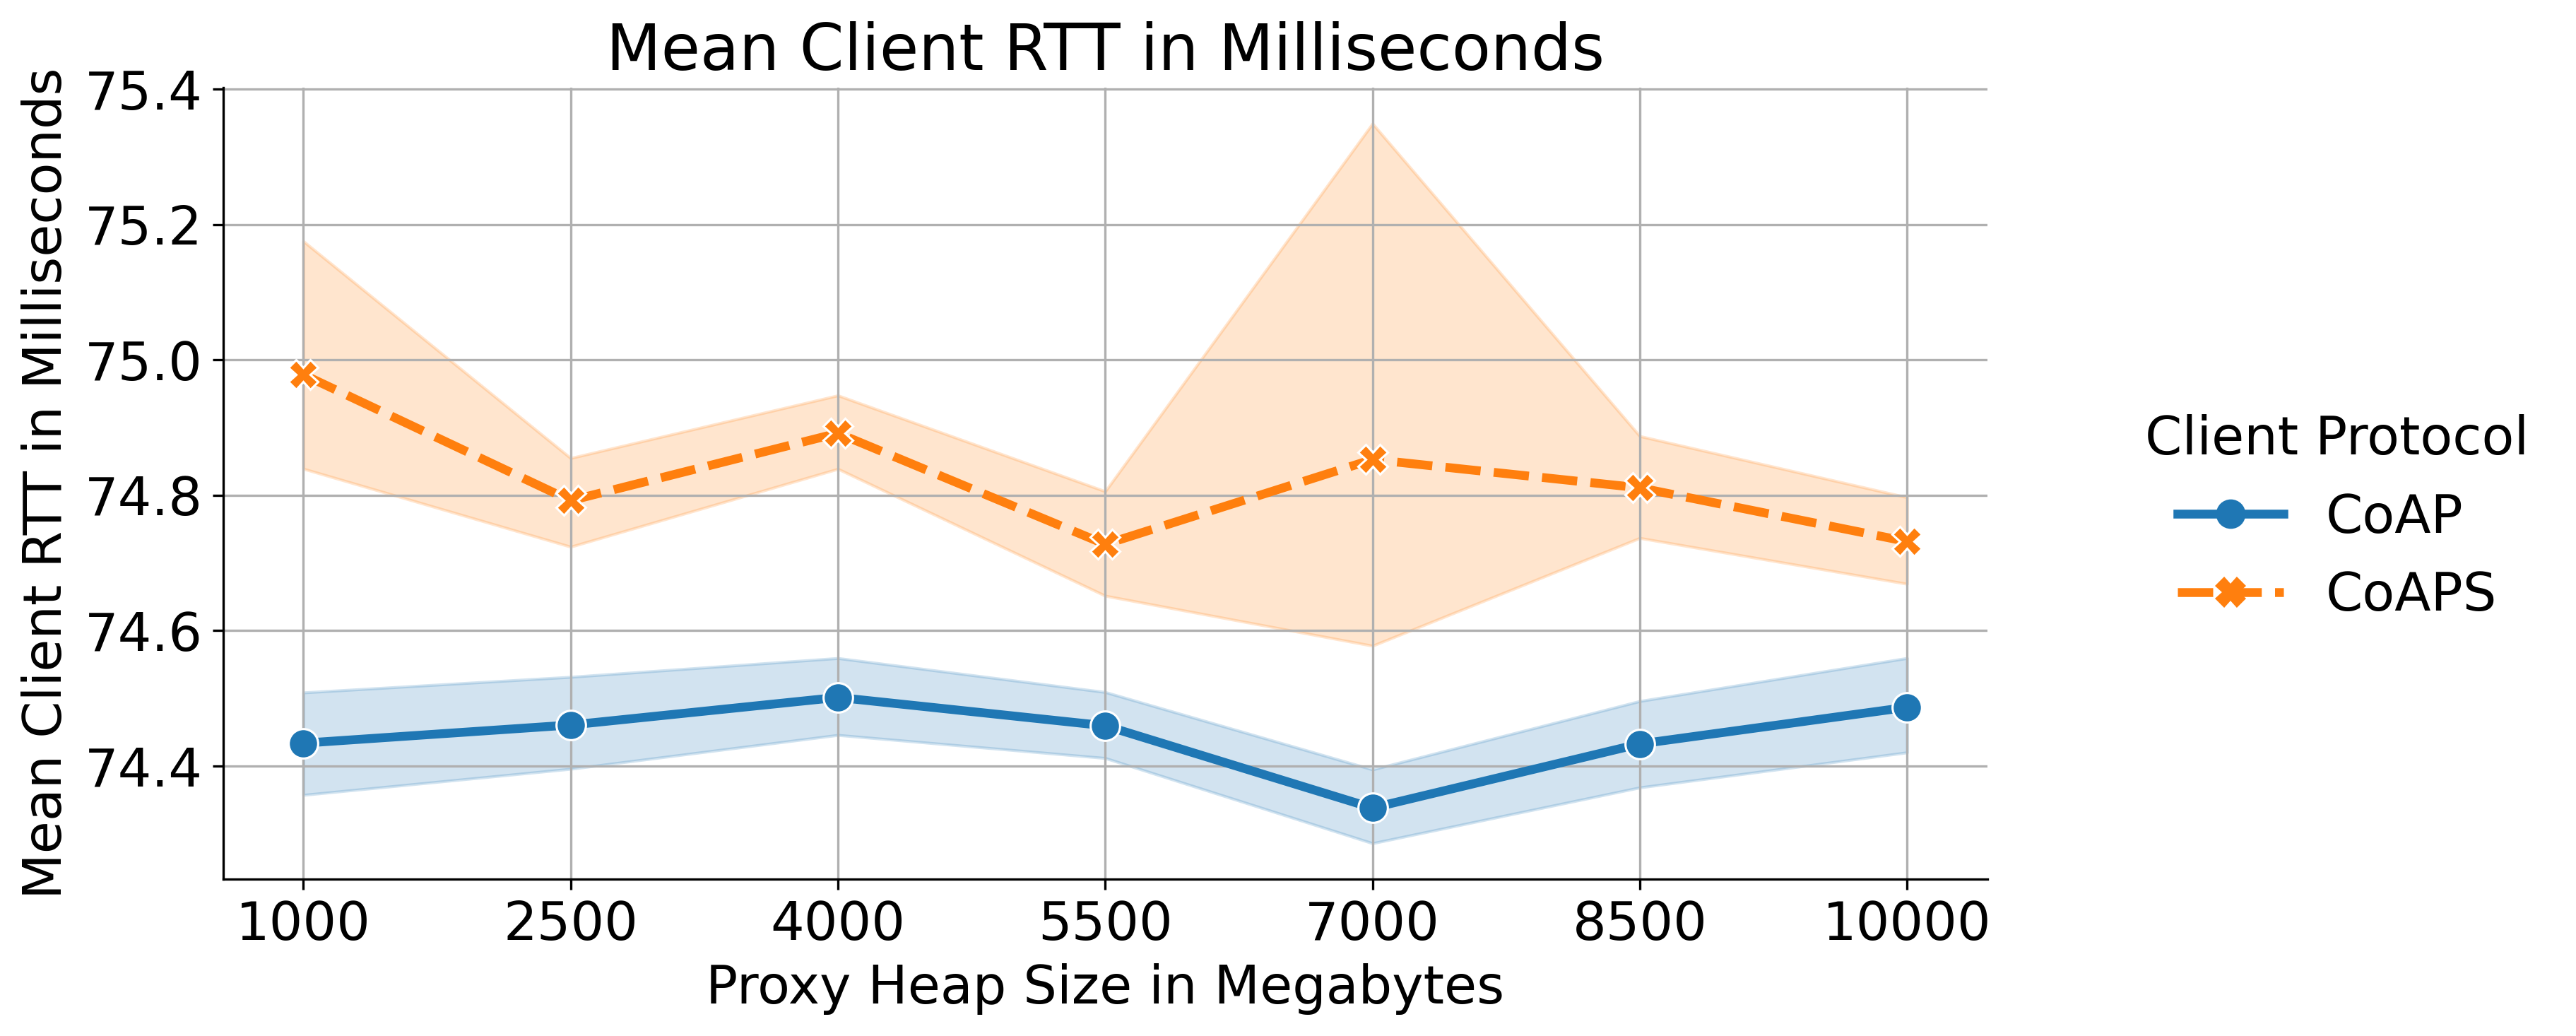

In [38]:
### Plot effect of RTT as a result of increasing number of clients

df = client_rps_df

g = sns.relplot(
  data=df,
  kind="line",
  x="heap_size_mb",
  y="mean_rtt_ms",
  hue="run_proxy_with_dtls",
  style="run_proxy_with_dtls",
  markers=True,
  markersize=10,
  aspect=2,
)

g.legend.set_title("Client Protocol")
g.set_xlabels("Proxy Heap Size in Megabytes")
g.set_ylabels("Mean Client RTT in Milliseconds")
g.set(xticks=np.arange(1000,10001,1500), title="Mean Client RTT in Milliseconds")

plt.grid(True, axis="both")
plt.show()

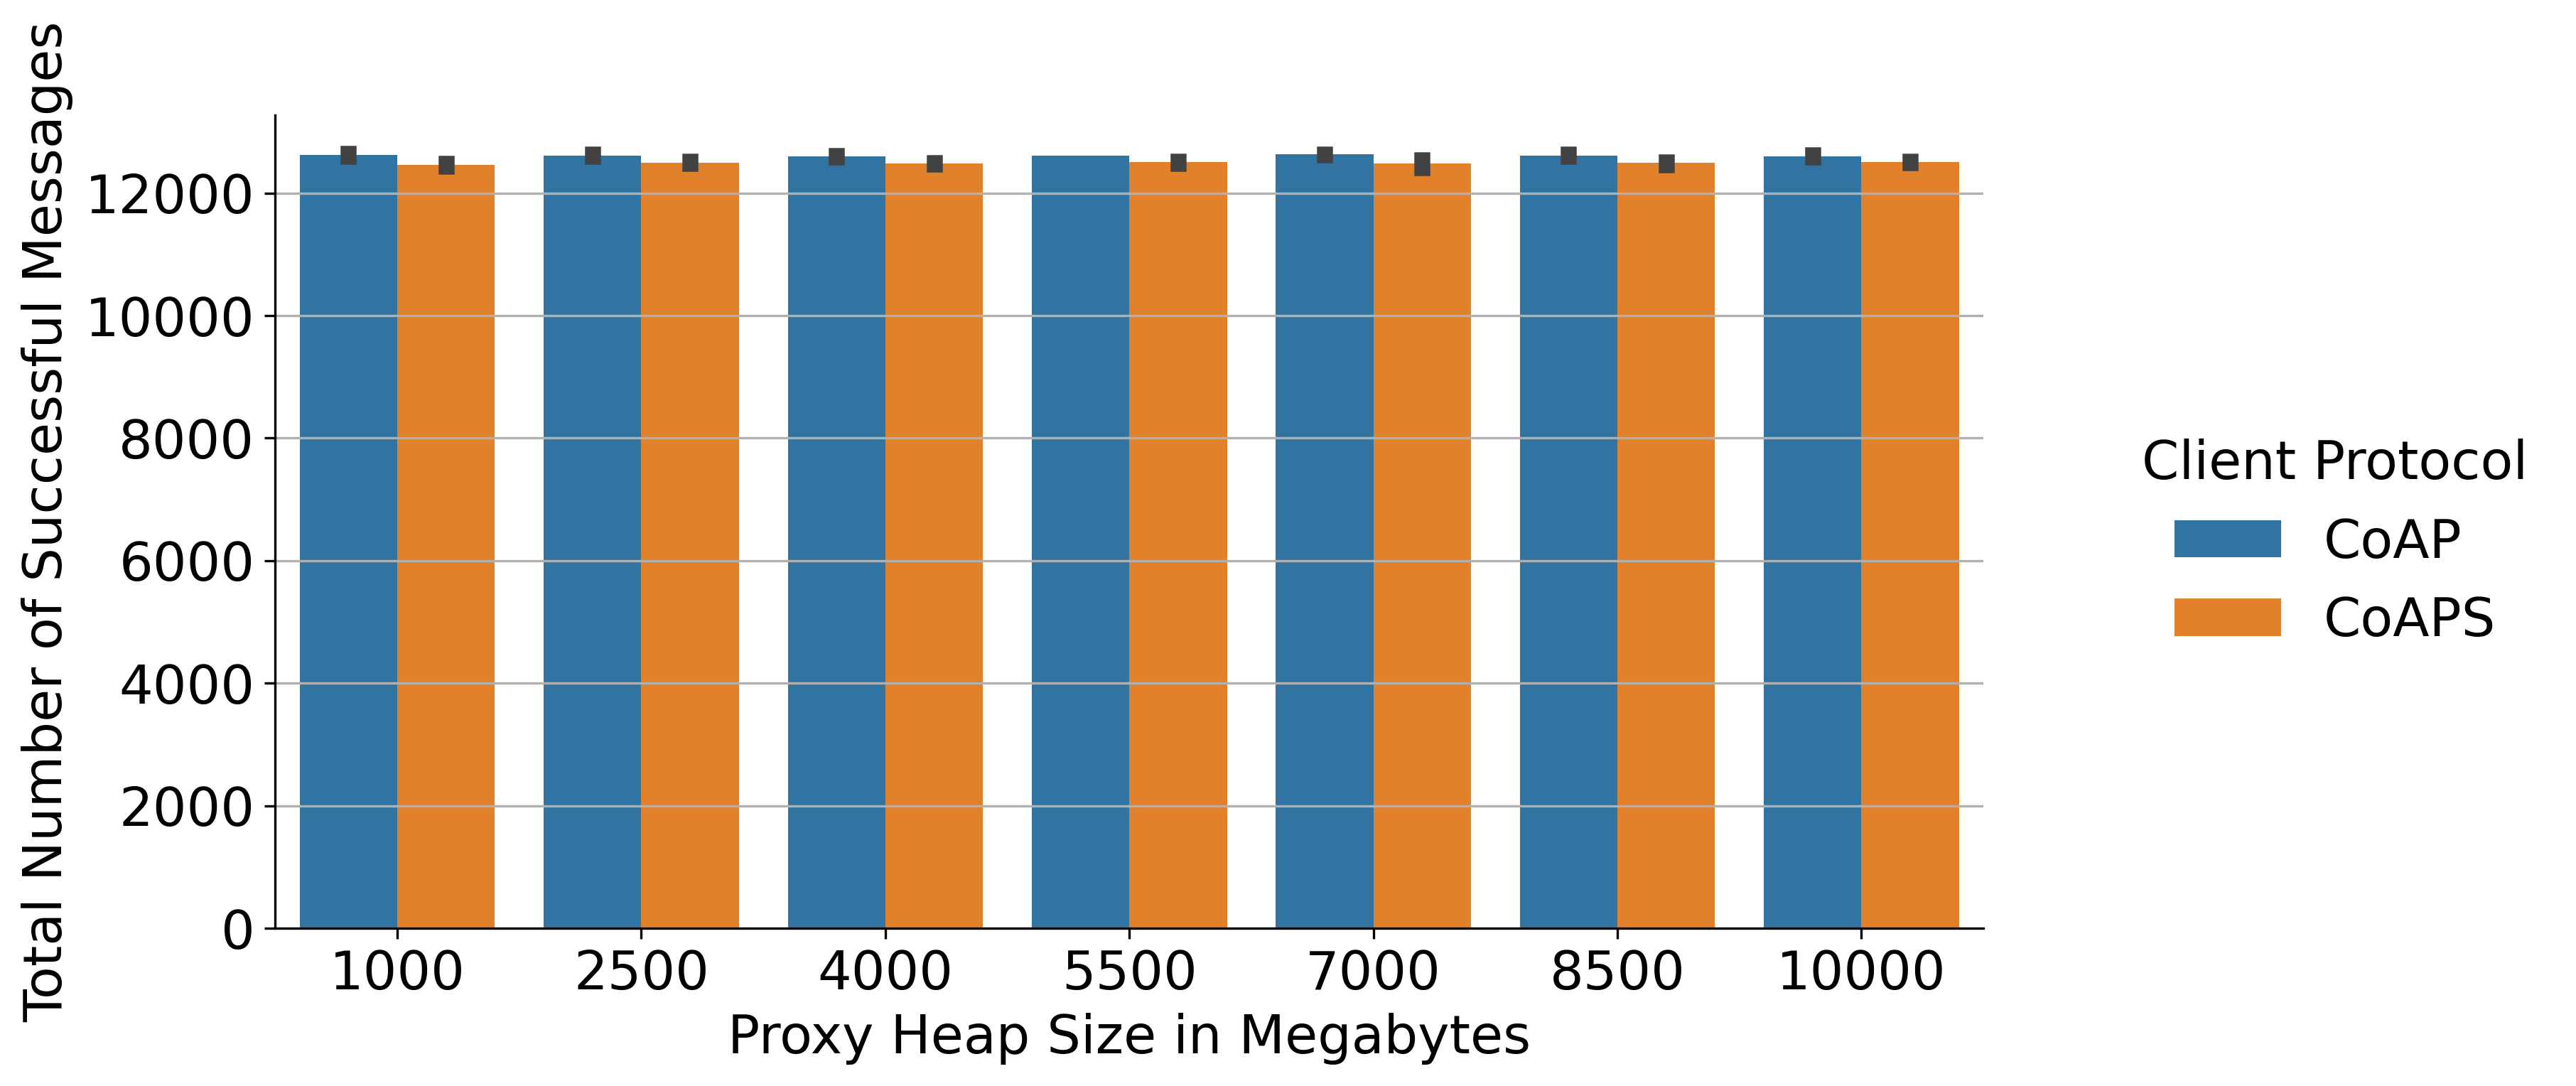

exp_id  \
0   thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
1   thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
2    thesis_group_controlling_proxy_heap_size_8clients_withattacker_1000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
3    thesis_group_controlling_proxy_heap_size_8clients_withattacker_1000MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
4    thesis_group_controlling_proxy_heap_size_8clients_withattacker_2500MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
5    thesis_group_controlling_proxy_heap_size_8clients_withattacker_2500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
6    thesis_group_controlling_proxy_heap_size_8clients_withattacker_4000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
7    thesis_group_controlling_proxy_heap_size_8clients_withattacker_4000MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
8    thesis_group_controlling_proxy_heap_size_8clients_withattacker_5500MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
9    thesis_group_controlling_proxy_heap_size_8clients_withattacker_5500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
10   thesis_group_controlling_proxy_heap_size_8clients_withattacker_7000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
11   thesis_group_controlling_proxy_heap_size_8clients_withattacker_7000MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
12   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
13   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   

   run_proxy_with_dtls  num_clients  mean_total_successful_messages  \
0                 CoAP            8                         12602.6   
1                CoAPS            8                         12504.0   
2                 CoAP            8                         12616.4   
3                CoAPS            8                         12462.0   
4                 CoAP            8                         12611.4   
5                CoAPS            8                         12493.8   
6                 CoAP            8                         12600.6   
7                CoAPS            8                         12476.6   
8                 CoAP            8                         12610.2   
9                CoAPS            8                         12501.0   
10                CoAP            8                         12630.0   
11               CoAPS            8                         12487.0   
12                CoAP            8                         12611.6   
13               CoAPS            8                         12489.6   

    mean_successful_messages_per_client  
0                              1575.325  
1                              1563.000  
2                              1577.050  
3                              1557.750  
4                              1576.425  
5                              1561.725  
6                              1575.075  
7                              1559.575  
8                              1576.275  
9                              1562.625  
10                             1578.750  
11                             1560.875  
12                             1576.450  
13                             1561.200

In [41]:
## Plot total number of successful messages.

client_rps_df["active_time_sec"] = client_rps_df["last_active_time"] - client_rps_df["first_active_time"]

df = (
  client_rps_df
  .groupby(by=["exp_id", "run_proxy_with_dtls", "num_clients", "heap_size_mb", "trial"])
  .agg(
    total_successful_messages=("num_successful_messages", "sum"),
    mean_active_time_sec=("active_time_sec", "mean"),
  )
  .reset_index()
)
df["amortized_successful_rps"] = df["total_successful_messages"] / df["mean_active_time_sec"] / df["num_clients"]

g = sns.catplot(
  data=df,
  kind="bar",
  x="heap_size_mb",
  y="total_successful_messages",
  hue="run_proxy_with_dtls",
  aspect=2,
)

g.set_xlabels("Proxy Heap Size in Megabytes")
g.set_ylabels("Total Number of Successful Messages")
g.legend.set_title("Client Protocol")

plt.grid(True, axis="y")
plt.show()

_df = (
  df
  .groupby(by=["exp_id", "run_proxy_with_dtls", "num_clients"])
  .agg(
    mean_total_successful_messages=("total_successful_messages", "mean"),
  )
  .reset_index()
)
_df["mean_successful_messages_per_client"] = _df["mean_total_successful_messages"] / _df["num_clients"]
_df

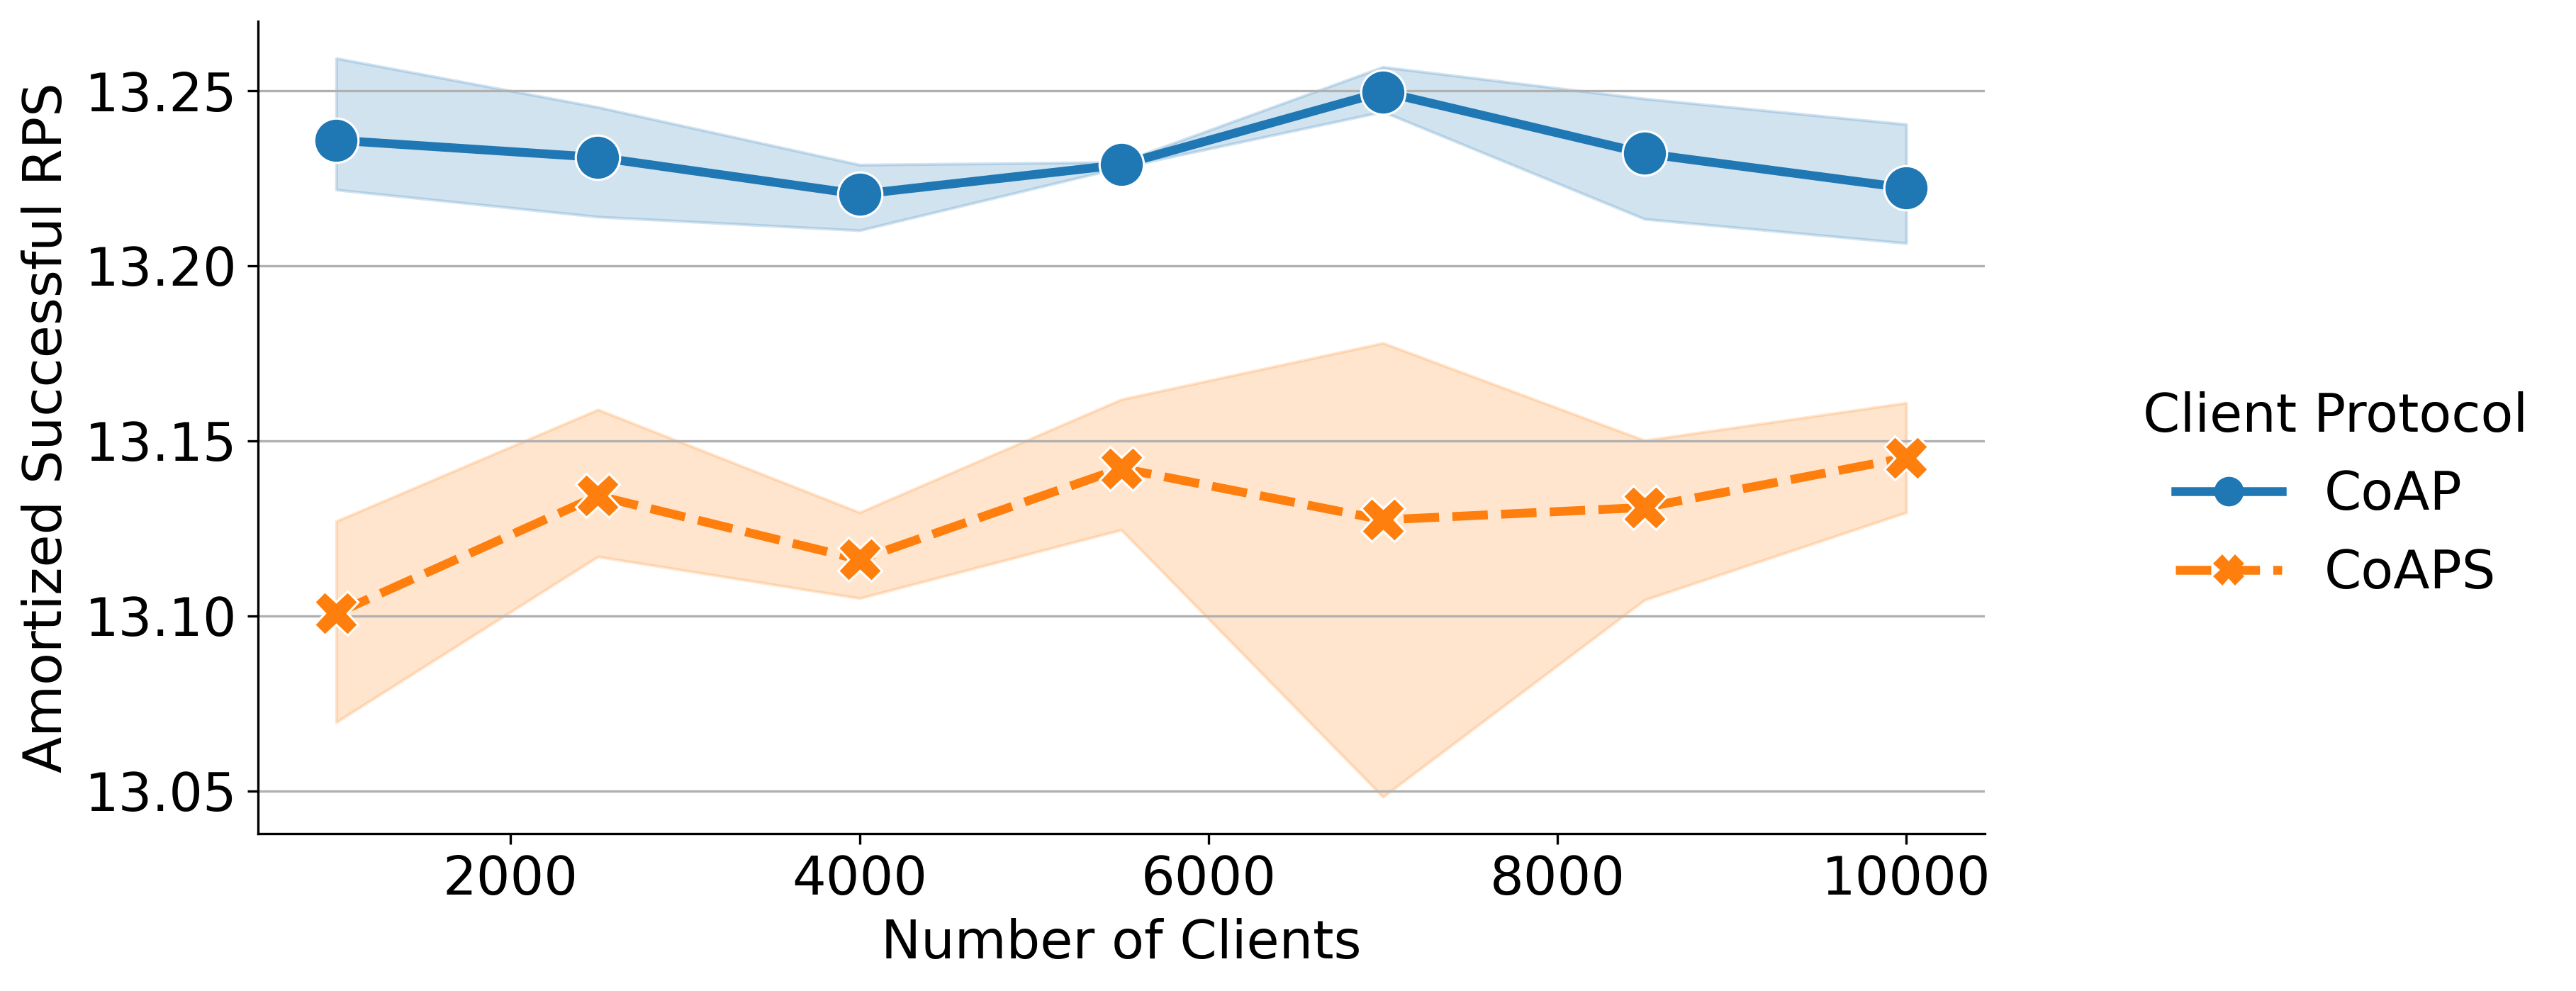

exp_id  \
0   thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
1   thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
2    thesis_group_controlling_proxy_heap_size_8clients_withattacker_1000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
3    thesis_group_controlling_proxy_heap_size_8clients_withattacker_1000MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
4    thesis_group_controlling_proxy_heap_size_8clients_withattacker_2500MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
5    thesis_group_controlling_proxy_heap_size_8clients_withattacker_2500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
6    thesis_group_controlling_proxy_heap_size_8clients_withattacker_4000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
7    thesis_group_controlling_proxy_heap_size_8clients_withattacker_4000MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
8    thesis_group_controlling_proxy_heap_size_8clients_withattacker_5500MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
9    thesis_group_controlling_proxy_heap_size_8clients_withattacker_5500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
10   thesis_group_controlling_proxy_heap_size_8clients_withattacker_7000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
11   thesis_group_controlling_proxy_heap_size_8clients_withattacker_7000MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
12   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
13   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   

   run_proxy_with_dtls  num_clients  heap_size_mb  \
0                 CoAP            8         10000   
1                CoAPS            8         10000   
2                 CoAP            8          1000   
3                CoAPS            8          1000   
4                 CoAP            8          2500   
5                CoAPS            8          2500   
6                 CoAP            8          4000   
7                CoAPS            8          4000   
8                 CoAP            8          5500   
9                CoAPS            8          5500   
10                CoAP            8          7000   
11               CoAPS            8          7000   
12                CoAP            8          8500   
13               CoAPS            8          8500   

    mean_amortized_successful_rps  mean_amortized_rps_messages_per_client  
0                       13.222227                                1.652778  
1                       13.145228                                1.643153  
2                       13.235873                                1.654484  
3                       13.100742                                1.637593  
4                       13.230990                                1.653874  
5                       13.134319                                1.641790  
6                       13.220429                                1.652554  
7                       13.116088                                1.639511  
8                       13.228872                                1.653609  
9                       13.142169                                1.642771  
10                      13.249692                                1.656211  
11                      13.127448                                1.640931  
12                      13.232085                                1.654011  
13             

In [42]:
g = sns.relplot(
  data=df,
  kind="line",
  x="heap_size_mb",
  y="amortized_successful_rps",
  hue="run_proxy_with_dtls",
  style="run_proxy_with_dtls",
  aspect=2,
  markers=True,
  markersize=15,
)

g.set_xlabels("Number of Clients")
g.set_ylabels("Amortized Successful RPS")
g.legend.set_title("Client Protocol")

plt.grid(True, axis="y")
plt.show()

_df = (
  df
  .groupby(by=["exp_id", "run_proxy_with_dtls", "num_clients", "heap_size_mb"])
  .agg(
    mean_amortized_successful_rps=("amortized_successful_rps", "mean"),
  )
  .reset_index()
)
_df["mean_amortized_rps_messages_per_client"] = _df["mean_amortized_successful_rps"] / _df["num_clients"]
_df

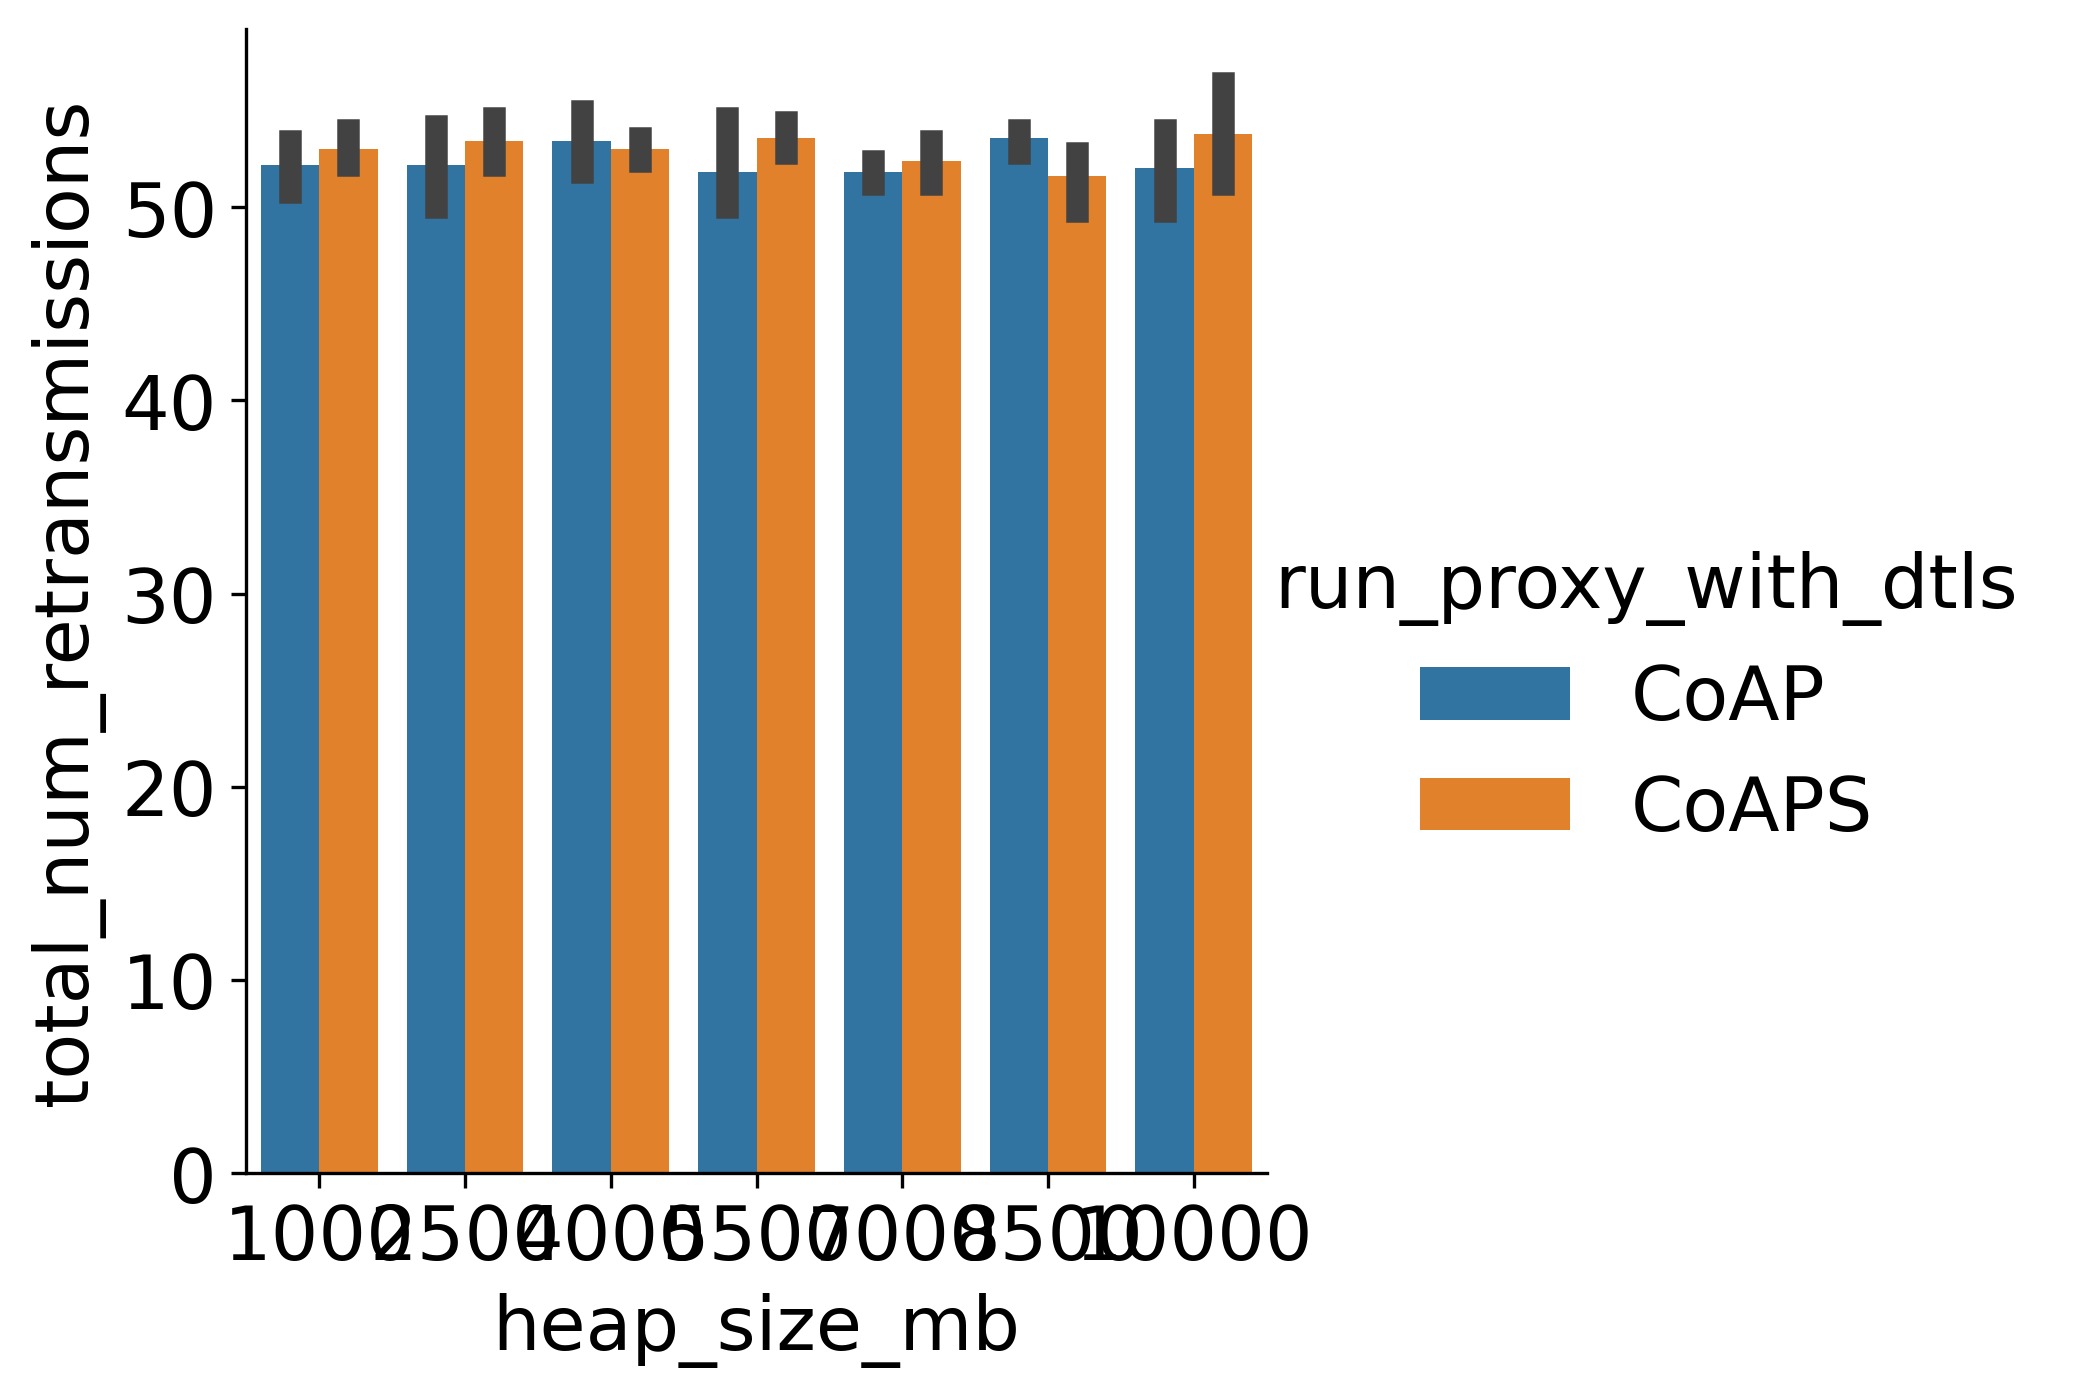

exp_id  \
0   thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
1   thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
2   thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
3   thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
4   thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
..                                                                                                                                              ...   
65   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
66   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
67   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
68   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
69   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   

    trial  num_clients run_proxy_with_dtls  heap_size_mb  \
0       1            8                CoAP         10000   
1       2            8                CoAP         10000   
2       3            8                CoAP         10000   
3       4            8                CoAP         10000   
4       5            8                CoAP         10000   
..    ...          ...                 ...           ...   
65      1            8               CoAPS          8500   
66      2            8               CoAPS          8500   
67      3            8               CoAPS          8500   
68      4            8               CoAPS          8500   
69      5            8               CoAPS          8500   

    total_num_retransmissions  
0                          49  
1                          53  
2                          55  
3                          54  
4                          49  
..                        ...  
65                         53  
66                         52  
67                         52  
68                         48  
69                         53  

[70 rows x 6 columns]

In [43]:
## Plot retransmissions as a function of clients and protocol.

df = (
  client_rps_df.groupby(by=["exp_id", "trial", "num_clients", "run_proxy_with_dtls", "heap_size_mb"])
  .agg(
    total_num_retransmissions=("total_num_retransmissions", "sum")
  )
  .reset_index()
)

g = sns.catplot(
  data=df,
  kind="bar",
  x="heap_size_mb",
  y="total_num_retransmissions",
  hue="run_proxy_with_dtls",
)
plt.show()

df[df["total_num_retransmissions"] > 0]

In [44]:
%%time

## Determine transaction success rate

# Combine send and receive events for clients.
client_events_df = client_sends_df.merge(client_recvs_df, on=["exp_id", "trial", "observer_id", "message_marker"], how="left")
client_events_df.rename(columns={
  "observe_timestamp_x": "send_timestamp",
  "observe_timestamp_y": "recv_timestamp",
}, inplace=True)
client_events_df["rtt_ms"] = 1e3 * (client_events_df["recv_timestamp"] - client_events_df["send_timestamp"])

# Edge case: sometimes clients will not receive a
# response back at the end of the experiment, so
# we ignore those messages, if any.
grouped_last_nan_indicies_to_remove = (
  client_events_df.reset_index()[
    client_events_df["recv_timestamp"].isna()
  ]
  .groupby(by=["exp_id", "trial", "observer_id", "message_marker"])
  .agg(
    last_nan_recv_timestamp=("recv_timestamp", "last"),
    original_index=("index", "last"),
  )
  .reset_index()
  ["original_index"]
  .unique()
)
client_events_df.drop(index=grouped_last_nan_indicies_to_remove, inplace=True)
client_events_df.reset_index(inplace=True)
client_events_df.drop(columns=["index"], inplace=True)

# Produce the total number of messages, and number 
# messages with a matching successful response.
grouped_client_events_df = (
  client_events_df
  .groupby(["exp_id", "trial", "observer_id"])
  .agg(
    unique_message_markers=("message_marker", "nunique"),
    num_successful_messages=("successful_message", "sum"),
  )
  .reset_index()
)

# Now compute the successful transaction rate.
grouped_client_events_df["transaction_success_rate"] = 100 * grouped_client_events_df["num_successful_messages"] / grouped_client_events_df["unique_message_markers"]

grouped_client_events_df = (
  grouped_client_events_df
  .merge(exp_df, on="exp_id", how="left")
  .replace({
    "run_proxy_with_dtls": {
      True : "CoAPS",
      False: "CoAP",
    },
  })
)

grouped_client_events_df

CPU times: user 4.56 s, sys: 382 ms, total: 4.94 s
Wall time: 4.94 s


exp_id  \
0    thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
1    thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
2    thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
3    thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
4    thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
..                                                                                                                                               ...   
555   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
556   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
557   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
558   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
559   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   

     trial observer_id  unique_message_markers num_successful_messages  \
0        1     client1                    1573                    1567   
1        1     client2                    1584                    1580   
2        1     client3                    1582                    1577   
3        1     client4                    1577                    1575   
4        1     client5                    1583                    1579   
..     ...         ...                     ...                     ...   
555      5     client4                    1562                    1558   
556      5     client5                    1568                    1568   
557      5     client6                    1563                    1560   
558      5     client7                    1571                    1570   
559      5     client8                    1567                    1563   

    transaction_success_rate attacker_rate  server_connections  \
0                  99.618563       100mbps                 256   
1                  99.747475       100mbps                 256   
2                  99.683944       100mbps                 256   
3                  99.873177       100mbps                 256   
4                  99.747315       100mbps                 256   
..                       ...           ...                 ...   
555                99.743918       100mbps                 256   
556                    100.0       100mbps                 256   
557                99.808061       100mbps                 256   
558                99.936346       100mbps                 256   
559                99.744735       100mbps                 256   

     max_keep_alive_requests  num_clients  ...  num_proxy_connections  \
0                          0            8  ...                     50   
1                          0            8  ...                     50   
2                          0            8  ...                     50   
3                          0            8  ...                     50   
4                          0            8  ...                     50   
..                       ...          ...  ...                    ...   
555                        0            8  ...                     50   
556                        0            8  ...     

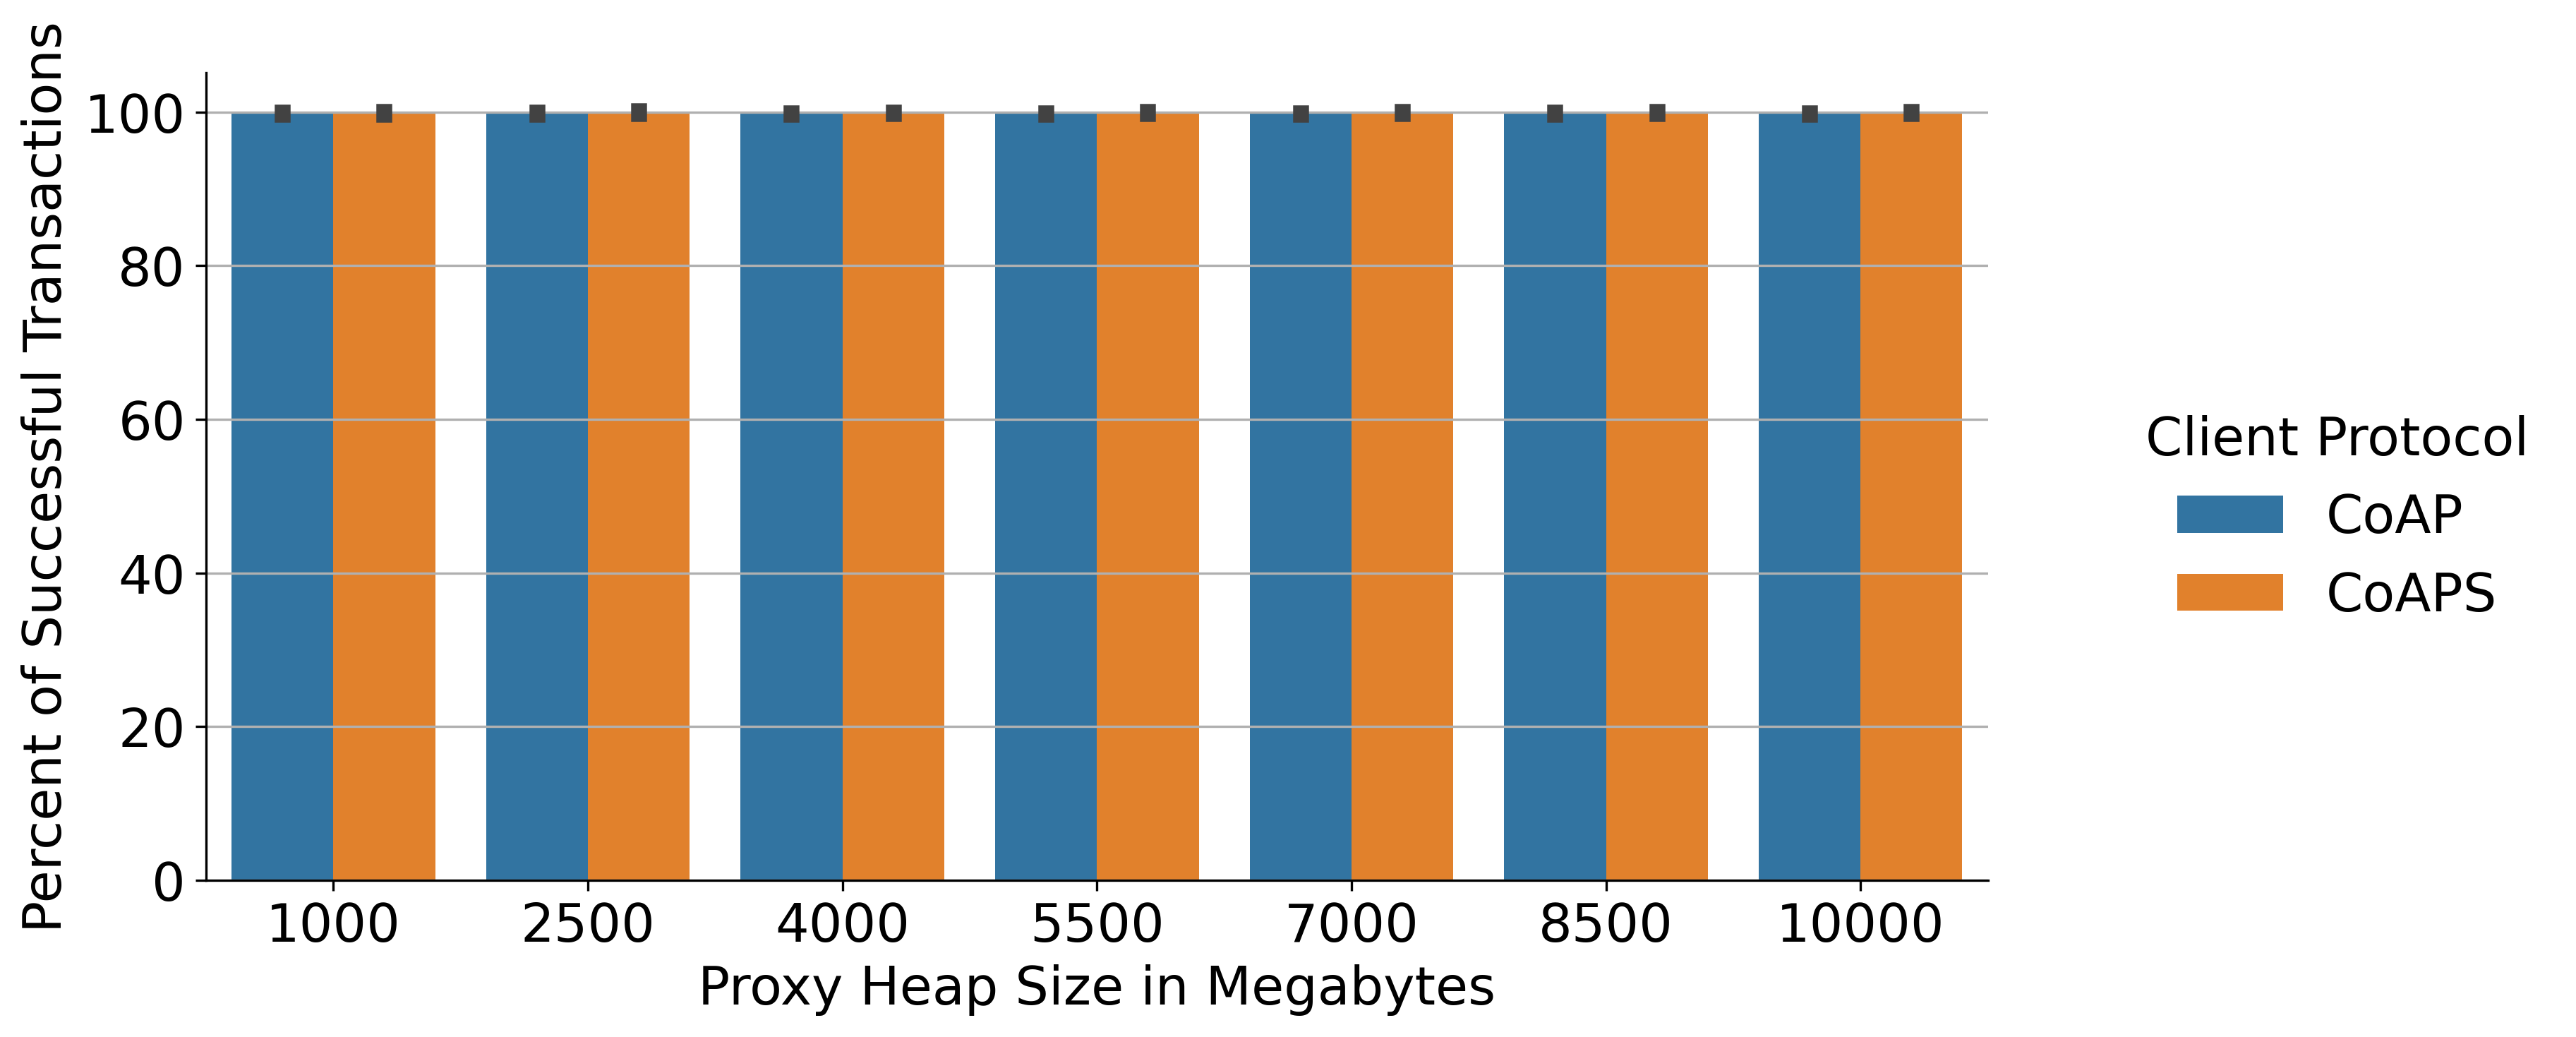

exp_id  \
0    thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
1    thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
2    thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
3    thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
4    thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
..                                                                                                                                               ...   
553   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
555   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
557   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
558   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
559   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   

     trial observer_id  unique_message_markers num_successful_messages  \
0        1     client1                    1573                    1567   
1        1     client2                    1584                    1580   
2        1     client3                    1582                    1577   
3        1     client4                    1577                    1575   
4        1     client5                    1583                    1579   
..     ...         ...                     ...                     ...   
553      5     client2                    1563                    1561   
555      5     client4                    1562                    1558   
557      5     client6                    1563                    1560   
558      5     client7                    1571                    1570   
559      5     client8                    1567                    1563   

    transaction_success_rate attacker_rate  server_connections  \
0                  99.618563       100mbps                 256   
1                  99.747475       100mbps                 256   
2                  99.683944       100mbps                 256   
3                  99.873177       100mbps                 256   
4                  99.747315       100mbps                 256   
..                       ...           ...                 ...   
553                99.872041       100mbps                 256   
555                99.743918       100mbps                 256   
557                99.808061       100mbps                 256   
558                99.936346       100mbps                 256   
559                99.744735       100mbps                 256   

     max_keep_alive_requests  num_clients  ...  num_proxy_connections  \
0                          0            8  ...                     50   
1                          0            8  ...                     50   
2                          0            8  ...                     50   
3                          0            8  ...                     50   
4                          0            8  ...                     50   
..                       ...          ...  ...                    ...   
553                        0            8  ...                     50   
555                        0            8  ...     

In [46]:
df = grouped_client_events_df

g = sns.catplot(
  data=df,
  kind="bar",
  x="heap_size_mb",
  y="transaction_success_rate",
  hue="run_proxy_with_dtls",
  ci="sd",
  aspect=2,
)

g.set_xlabels("Proxy Heap Size in Megabytes")
g.set_ylabels("Percent of Successful Transactions")
g.legend.set_title("Client Protocol")

plt.grid(True, axis="y")
plt.show()

grouped_client_events_df[
  grouped_client_events_df["transaction_success_rate"] < 100
]

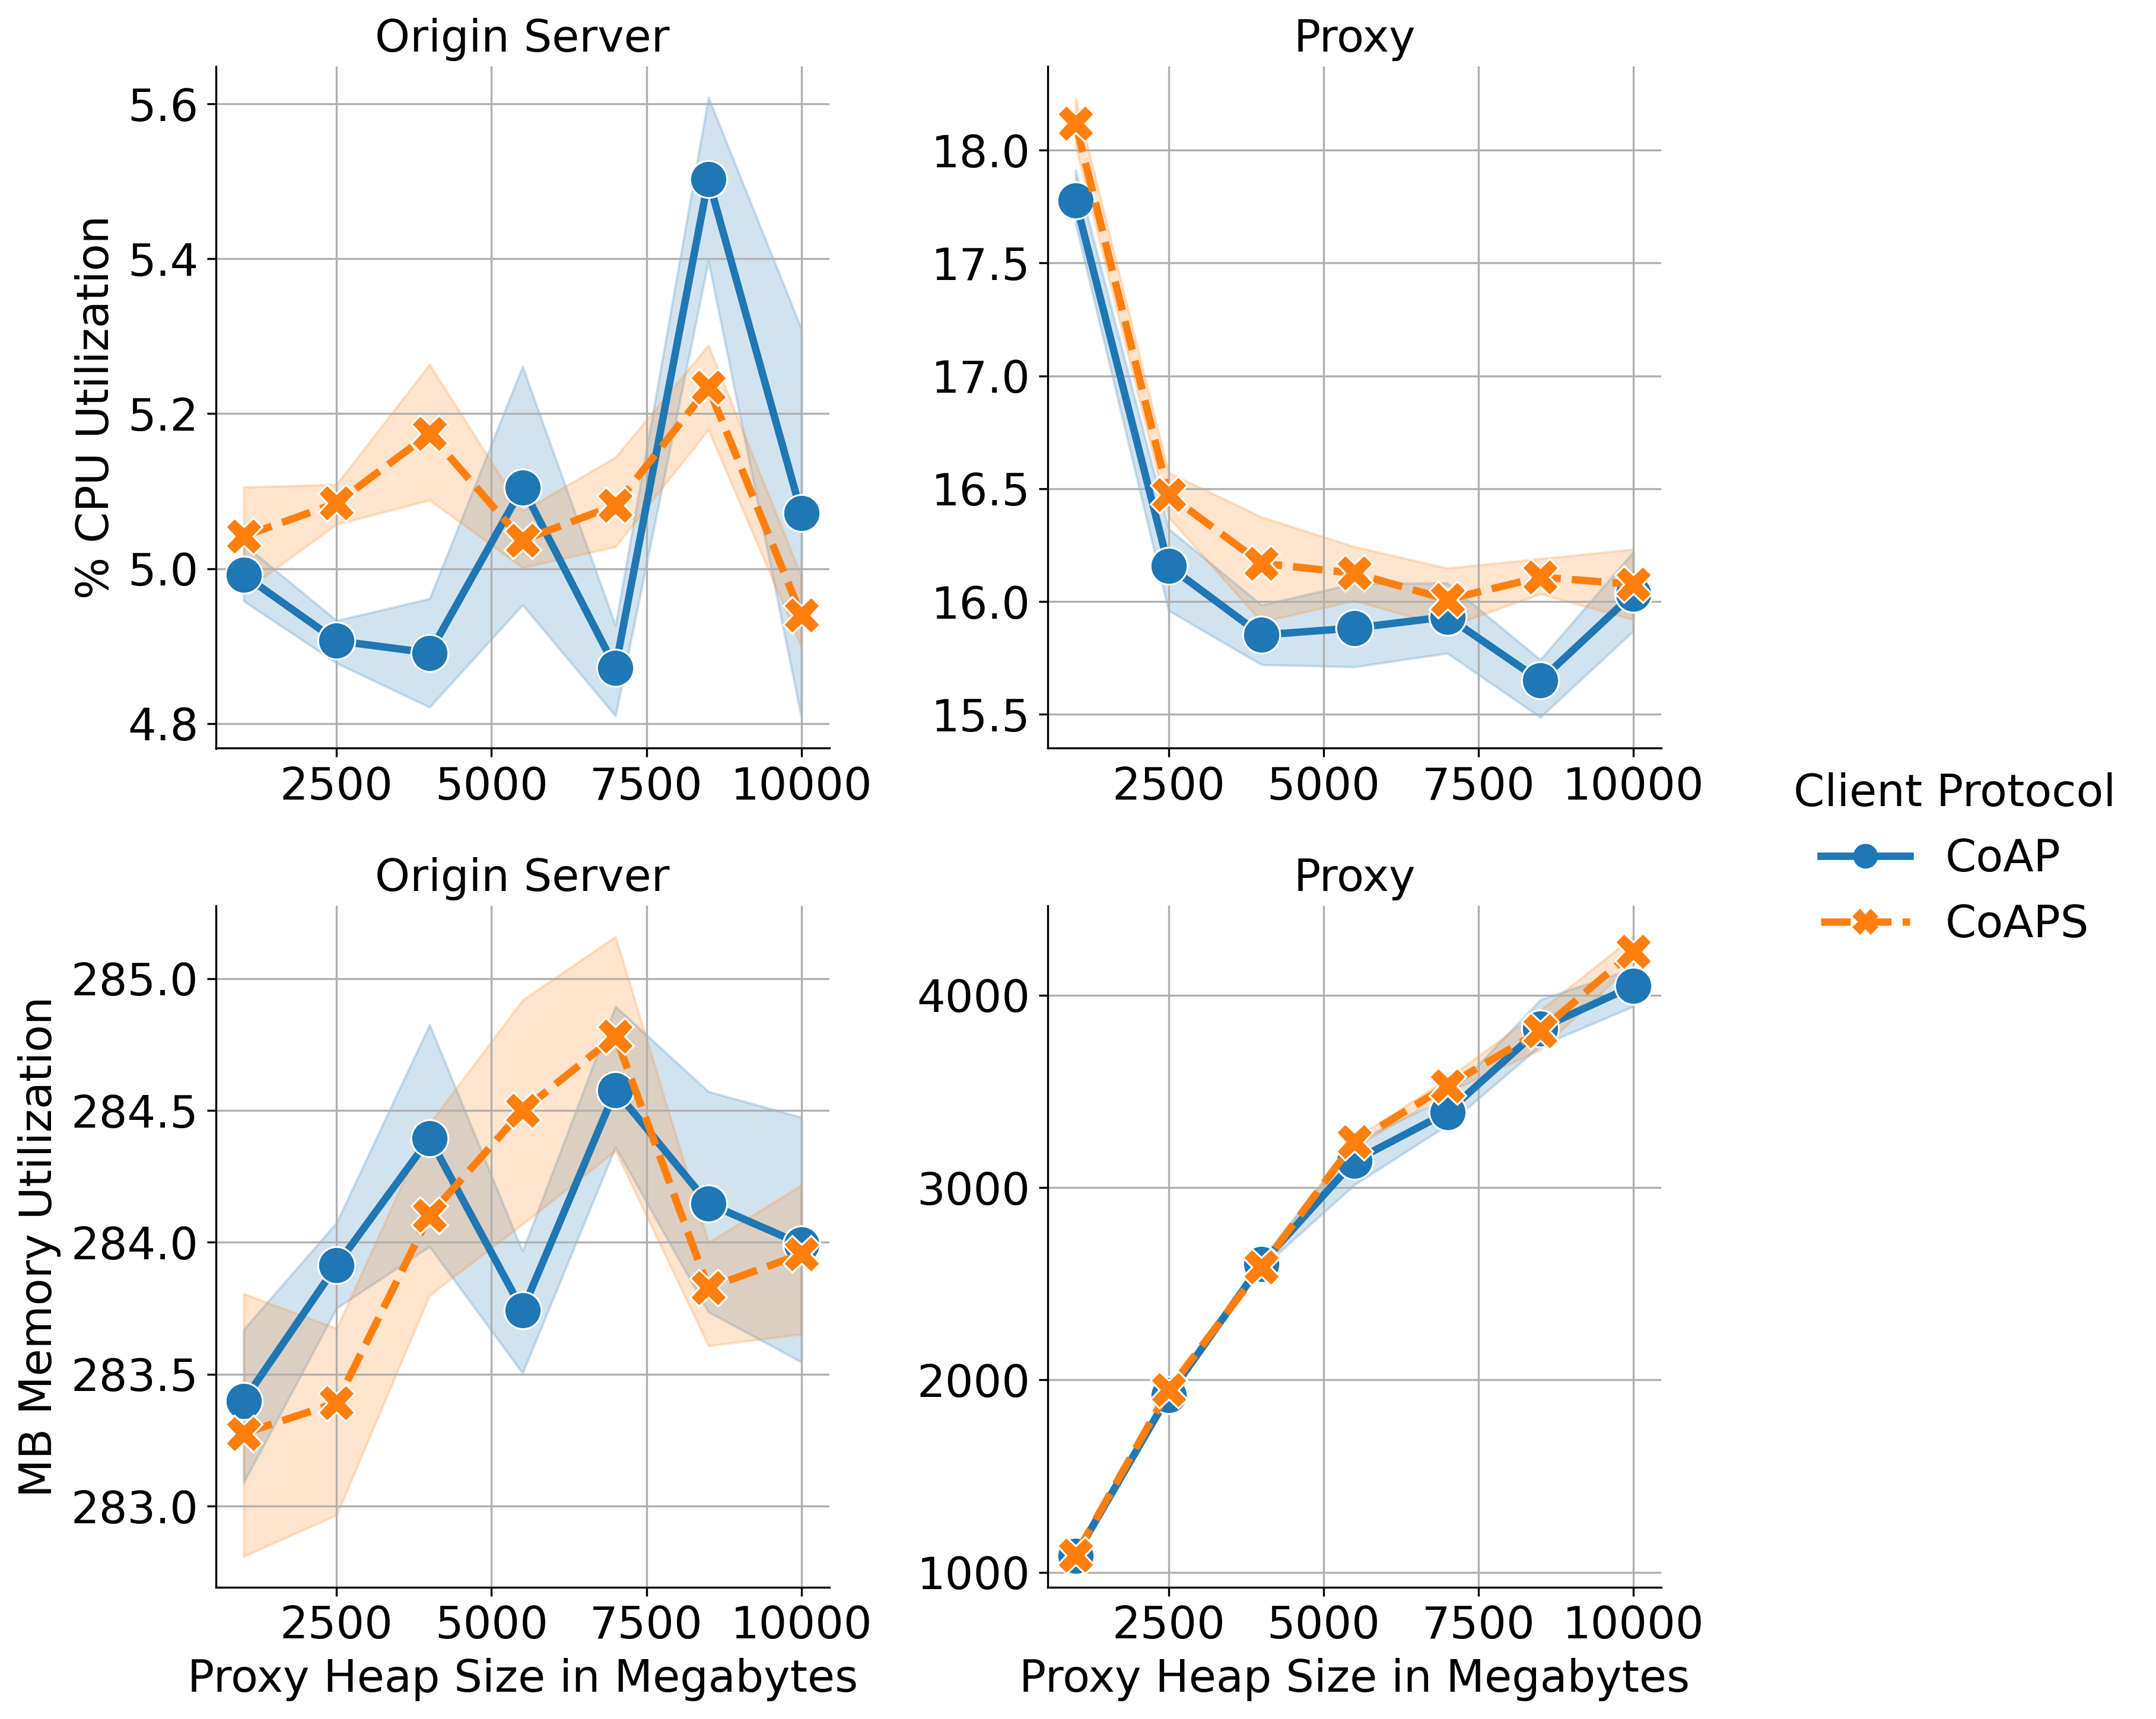

CPU times: user 4.33 s, sys: 193 ms, total: 4.52 s
Wall time: 4.22 s


exp_id  \
0    thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
1    thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
2    thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
3    thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
4    thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
..                                                                                                                                               ...   
275   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
276   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
277   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
278   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
279   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   

     trial    observer_id            metric_type    avg_value  min_value  \
0        1  Origin Server      % CPU Utilization     5.438571        0.4   
1        1          Proxy      % CPU Utilization    16.111429        0.5   
2        1  Origin Server  MB Memory Utilization   283.457851      261.0   
3        1          Proxy  MB Memory Utilization  4197.317726      259.0   
4        2  Origin Server      % CPU Utilization     5.285000        0.4   
..     ...            ...                    ...          ...        ...   
275      4          Proxy  MB Memory Utilization  3648.215000      259.0   
276      5  Origin Server      % CPU Utilization     5.288571        0.5   
277      5          Proxy      % CPU Utilization    16.010000        0.4   
278      5  Origin Server  MB Memory Utilization   283.945455      262.0   
279      5          Proxy  MB Memory Utilization  3727.527454      259.0   

     max_value attacker_rate  server_connections  max_keep_alive_requests  \
0         22.2       100mbps                 256                        0   
1         90.4       100mbps                 256                        0   
2        296.0       100mbps                 256                        0   
3       7063.0       100mbps                 256                        0   
4         22.5       100mbps                 256                        0   
..         ...           ...                 ...                      ...   
275     6006.0       100mbps                 256                        0   
276       22.5       100mbps                 256                        0   
277       87.2       100mbps                 256                        0   
278      309.0       100mbps                 256                        0   
279     6112.0       100mbps                 256                        0   

     ...  num_proxy_connections  request_timeout  max_retries  \
0    ...                     50                5            2   
1    ...                     50                5            2   
2    ...                     50                5            2   
3    ...                     50                5            2   
4    ...                     50                5            2   
..   ...                    ...              ...          ...   
275  ...                

In [52]:
%%time

## Measure proxy and server metrics.

df = (
  metric_df.replace({
    "metric_type": {
      "cpu_utilization": "% CPU Utilization",
      "memory_utilization": "MB Memory Utilization",
    },
    "observer_id": {
      "proxy": "Proxy",
      "originserver": "Origin Server",
    },
  })
)

g = sns.relplot(
  data=df,
  kind="line",
  x="heap_size_mb",
  y="avg_value",
  col="observer_id",
  row="metric_type",
  hue="run_proxy_with_dtls",
  style="run_proxy_with_dtls",
  markers=True,
  markersize=15,
  facet_kws={
    "sharey": False,
    "sharex": False,
  },
)

g.set_titles(
  template="{col_name}",
  col_template="{col_name}",
  row_template="{row_name}",
)
g.set_xlabels("Proxy Heap Size in Megabytes")
g.set_ylabels("Average Metric Value")
g.legend.set_title("Client Protocol")

g.axes[0,0].set_ylabel("% CPU Utilization")
g.axes[0,1].set_ylabel("")
# g.axes[0,0].set_ylim(0,4)
# g.axes[0,1].set_ylim(0,4)

g.axes[1,0].set_ylabel("MB Memory Utilization")
g.axes[1,1].set_ylabel("")
# g.axes[1,0].set_ylim(250, 500)
# g.axes[1,1].set_ylim(250, 500)

g.axes[0,0].grid(True, axis="both")
g.axes[0,1].grid(True, axis="both")
g.axes[1,0].grid(True, axis="both")
g.axes[1,1].grid(True, axis="both")

plt.show()

df

In [55]:
%%time

## Measure proxy and server connection management.
##
## We currently do not insert connection events to
## the database, so we have to read from the processed
## connection files.

ALL_EXPERIMENTS_DATA_HOME = "/home/ubuntu/dos-californium/deter/expdata/real/final"

def read_exp_trial_node_connections(exp_id):
  """
  Read all processed connection dumps in an experiment `exp_id`.
  """
  experiment_dir = os.path.join(ALL_EXPERIMENTS_DATA_HOME, exp_id)

  df = (
    pl
    .scan_parquet(
      f"{experiment_dir}/*/{exp_id}.connections.parquet"
    )
  )
  lazy_dfs.append(df)

lazy_dfs = list()
for exp_id in exp_df["exp_id"].unique():
  read_exp_trial_node_connections(exp_id)

connections_df = (
  pl
  .concat(lazy_dfs)

  # Filter for proxy's view of syn-acks or fin-acks coming from server
  .filter(
    (pl.col("observer_id") == "proxy")
    & ((pl.col("is_syn") == 1) | (pl.col("is_fin") == 1))
    & (pl.col("info").str.contains(", ACK]"))
    & (pl.col("src_port") == 443)
  )
  # Group by experiment, trial, and observer, then accummulate
  # syn-acks and fin-acks in a list, along with their corresponding
  # timestamps of occurrence for each group.
  .groupby(
    by=["exp_id", "trial", "observer_id"],
    maintain_order=True
  )
  .agg([
    pl.col("timestamp").alias("timestamp"),
    pl.col("is_syn").cumsum().alias("cum_syn"),
    pl.col("is_fin").cumsum().alias("cum_fin"),
  ])
  # Explode the cumulative syns and fins, and their times, then
  # subtract them to get a view of how many open connections there
  # are in the experiment as a function of time
  .explode(columns=["timestamp", "cum_syn", "cum_fin"])
  .with_columns([
    (pl.col("cum_syn") - pl.col("cum_fin")).alias("open_connections")
  ])

  # And finally convert to pandas for plotting.
  .collect()
  .to_pandas()
)

# This method of counting does not include the original 0 connections
# at time 0 for each node in each trial -- so we add that manually.
records = list()
for e in connections_df["exp_id"].unique():
  for t in connections_df["trial"].unique():
    for o in connections_df["observer_id"].unique():
      records.append({
        "exp_id"          : e,
        "trial"           : t,
        "observer_id"     : o,
        "timestamp"       : 0.0,
        "cum_syn"         : 0,
        "cum_fin"         : 0,
        "open_connections": 0,
      })
connections_df = (
  pd.concat(
    [connections_df, pd.DataFrame.from_records(records)]
  )
  .sort_values(by=["exp_id", "trial", "observer_id", "timestamp"])
)

# This method also does not include a connection count at the last time
# the proxy is meant to be active -- so we fill that value in based on the
# last value.
last_connection_df = (
  connections_df
  .groupby(by=["exp_id", "trial", "observer_id"], sort=True)
  .agg(
    max_timestamp=("timestamp", "max"),
    last_timestamp=("timestamp", "last"),
    max_open_connections=("open_connections", "max"),
    last_open_connections=("open_connections", "last"),
    last_cum_syn=("cum_syn", "last"),
    last_cum_fin=("cum_fin", "last"),
  )
  .reset_index()
)
# assert last_connection_df["max_timestamp"].equals(last_connection_df["last_timestamp"])
# assert last_connection_df["max_open_connections"].equals(last_connection_df["last_open_connections"])
records = list()
for r in last_connection_df.to_dict(orient="records"):
  records.append({
    "exp_id"          : r["exp_id"],
    "trial"           : r["trial"],
    "observer_id"     : r["observer_id"],
    "timestamp"       : 140,
    "cum_syn"         : r["last_cum_syn"],
    "cum_fin"         : r["last_cum_fin"],
    "open_connections": r["last_open_connections"],
  })
connections_df = (
  pd.concat(
    [connections_df, pd.DataFrame.from_records(records)]
  )
  .sort_values(by=["exp_id", "trial", "observer_id", "timestamp"])
)

connections_df = (
  connections_df
  .merge(exp_df, on="exp_id", how="left")
  .replace({
    "run_proxy_with_dtls": {
      True : "CoAPS",
      False: "CoAP",
    },
  })
)

connections_df

CPU times: user 3min 7s, sys: 3min 44s, total: 6min 52s
Wall time: 20.9 s


exp_id  \
0     thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
1     thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
2     thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
3     thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
4     thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
...                                                                                                                                               ...   
7915   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
7916   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
7917   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
7918   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
7919   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   

      trial observer_id   timestamp  cum_syn  cum_fin  open_connections  \
0         1       proxy    0.000000        0        0                 0   
1         1       proxy    0.064351        1        0                 1   
2         1       proxy    1.402079        2        0                 2   
3         1       proxy    2.127625        3        0                 3   
4         1       proxy    6.663204        4        0                 4   
...     ...         ...         ...      ...      ...               ...   
7915      5       proxy  126.059631       55       52                 3   
7916      5       proxy  126.381256       55       53                 2   
7917      5       proxy  129.278196       55       54                 1   
7918      5       proxy  131.205116       55       55                 0   
7919      5       proxy  140.000000       55       55                 0   

     attacker_rate  server_connections  max_keep_alive_requests  ...  \
0          100mbps                 256                        0  ...   
1          100mbps                 256                        0  ...   
2          100mbps                 256                        0  ...   
3          100mbps                 256                        0  ...   
4          100mbps                 256                        0  ...   
...            ...                 ...                      ...  ...   
7915       100mbps                 256                        0  ...   
7916       100mbps                 256                        0  ...   
7917       100mbps                 256                        0  ...   
7918       100mbps                 256                        0  ...   
7919       100mbps                 256                        0  ...   

      num_proxy_connections  request_timeout  max_retries  \
0                        50                5            2   
1                        50                5            2   
2                        50                5            2   
3                        50                5            2   
4                        50                5            2   
...                     ...              ...          ...   
7915                     50                5            2   
7916                     50                5        

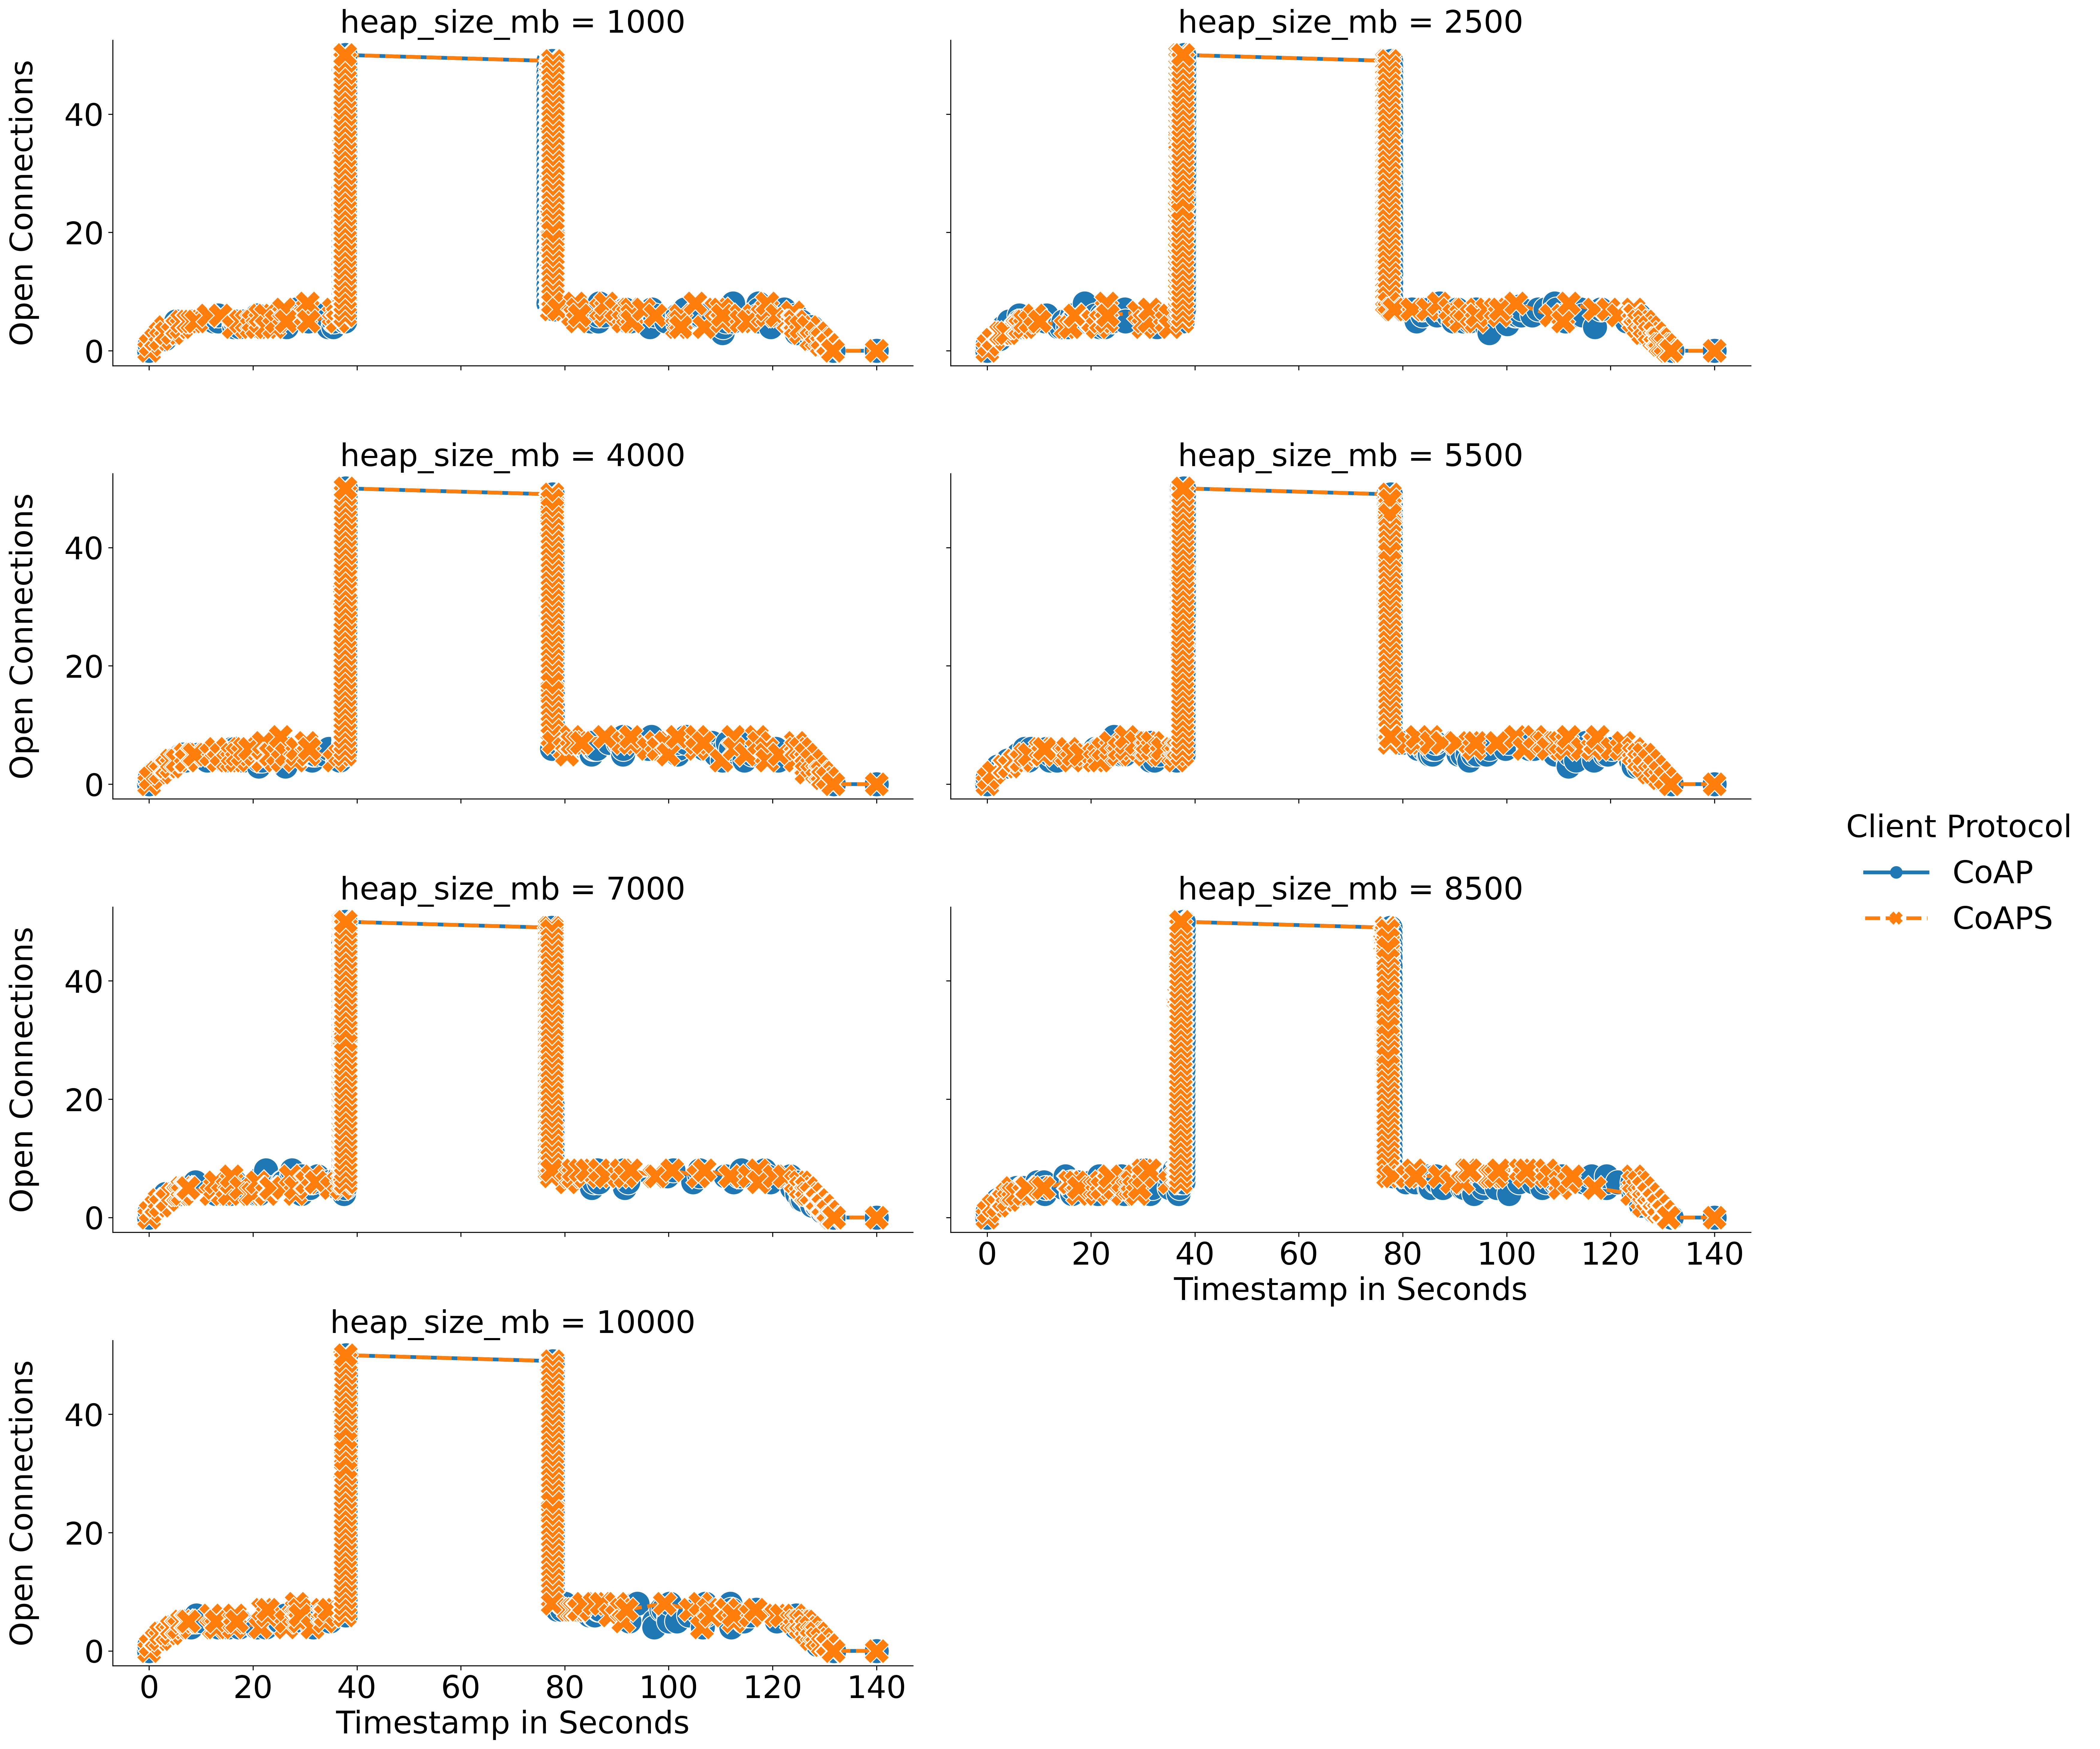

CPU times: user 10.7 s, sys: 687 ms, total: 11.4 s
Wall time: 11.1 s


In [58]:
%%time

## Measure proxy and server connection management.

df = connections_df

plt.rcParams['font.size'] = '25'

g = sns.relplot(
  data=df,
  kind="line",
  x="timestamp",
  y="open_connections",
  hue="run_proxy_with_dtls",
  style="run_proxy_with_dtls",
  col="heap_size_mb",
  col_wrap=2,
  markers=True,
  markersize=20,
  facet_kws={
    "sharey": True,
    "sharex": True,
  },
  aspect=2,
)
g.set_xlabels("Timestamp in Seconds")
g.set_ylabels("Open Connections", labelpad=20)
g.legend.set_title("Client Protocol")
# g.set(yticks=np.arange(1,9,1))
# for i in range(8):
#   g.axes[i].grid(True, axis="both")

plt.show()

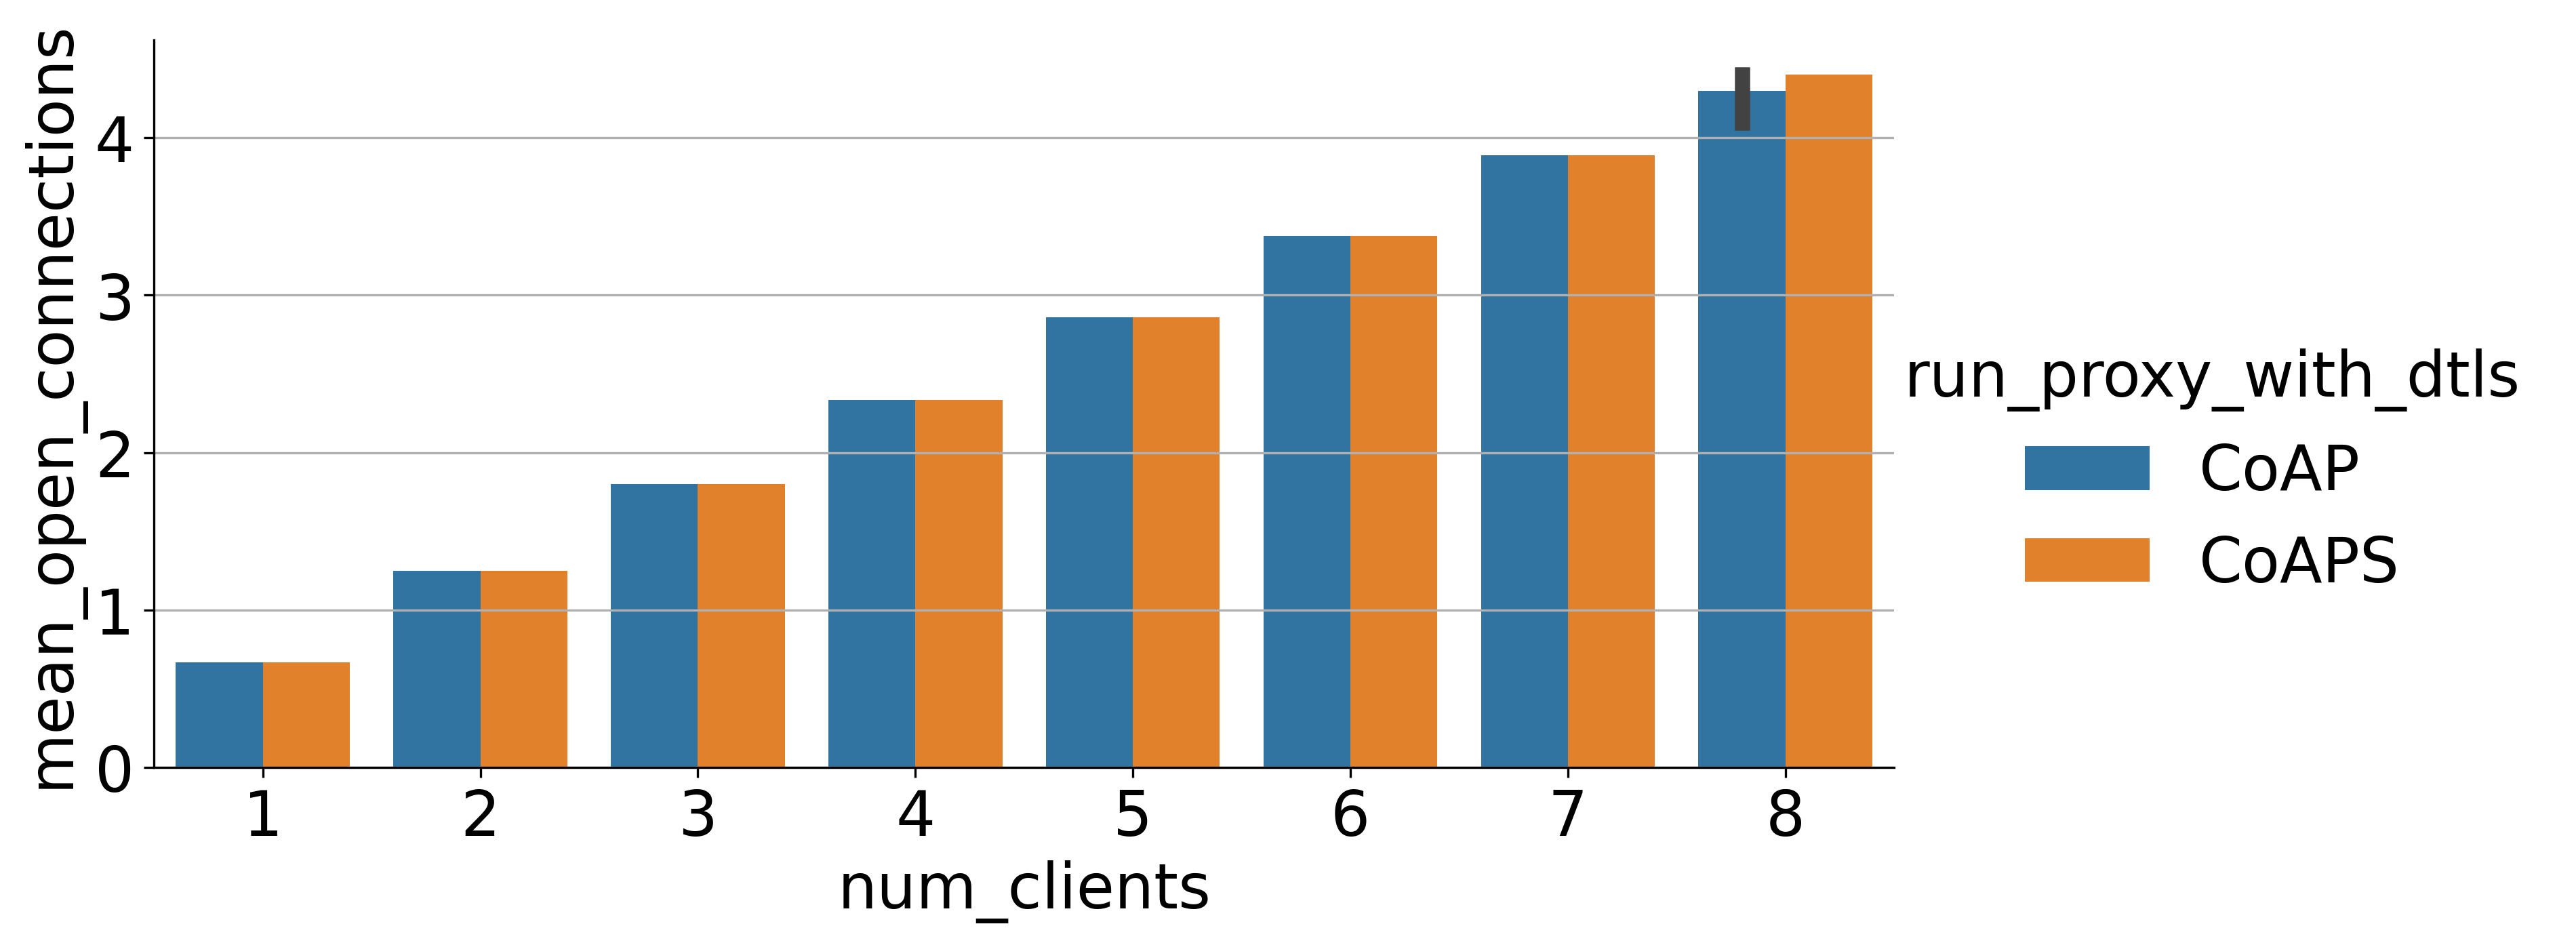

CPU times: user 1.75 s, sys: 222 ms, total: 1.98 s
Wall time: 1.65 s


exp_id  trial  \
0   updated_thesis_group_num_clients_1clients_noattacker_coap_https      1   
1   updated_thesis_group_num_clients_1clients_noattacker_coap_https      2   
2   updated_thesis_group_num_clients_1clients_noattacker_coap_https      3   
3   updated_thesis_group_num_clients_1clients_noattacker_coap_https      4   
4   updated_thesis_group_num_clients_1clients_noattacker_coap_https      5   
..                                                              ...    ...   
75  updated_thesis_group_num_clients_8clients_noattacker_dtls_https      1   
76  updated_thesis_group_num_clients_8clients_noattacker_dtls_https      2   
77  updated_thesis_group_num_clients_8clients_noattacker_dtls_https      3   
78  updated_thesis_group_num_clients_8clients_noattacker_dtls_https      4   
79  updated_thesis_group_num_clients_8clients_noattacker_dtls_https      5   

   observer_id  num_clients run_proxy_with_dtls  mean_open_connections  
0        proxy            1                CoAP               0.666667  
1        proxy            1                CoAP               0.666667  
2        proxy            1                CoAP               0.666667  
3        proxy            1                CoAP               0.666667  
4        proxy            1                CoAP               0.666667  
..         ...          ...                 ...                    ...  
75       proxy            8               CoAPS               4.400000  
76       proxy            8               CoAPS               4.400000  
77       proxy            8               CoAPS               4.400000  
78       proxy            8               CoAPS               4.400000  
79       proxy            8               CoAPS               4.400000  

[80 rows x 6 columns]

In [20]:
%%time

df = (
  connections_df
  .groupby(by=["exp_id", "trial", "observer_id", "num_clients", "run_proxy_with_dtls"])
  .agg(
    mean_open_connections=("open_connections", "mean"),
  )
  .reset_index()
)

g = sns.catplot(
  data=df,
  kind="bar",
  x="num_clients",
  y="mean_open_connections",
  hue="run_proxy_with_dtls",
  aspect=2,
)

plt.grid(True, axis="y")
plt.show()

df